## Simple Regression Model for Traffic Flow Prediction after removing data with low confidence value in INRIX data
This task aims to remove the INRIX data point with low confidence value, and then implement simple regression models (Polynomial, Decision Tree, Random Forest) to predict the traffic flow based on Mcs data and INRIX data

## 0. Environment Setting

### 0.1 Import Libraries & Define Constants

In [ ]:
from google.colab import drive
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn
from datetime import datetime
from datetime import timedelta


# Constants
MOVING_AVERAGE_WINDOW = 30
SCORE_THRESHOLD = 20

#MCS decision tree parameters:

#INRIX decision tree parameters:

#MCS random forest parameters:

#INRIX random forest parameters:





/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 0.2 Mount Google drive, Set working directory

In [ ]:
drive.mount('/content/gdrive')
print(os.path.abspath('.'))
root_path = '/content/gdrive/My Drive/degree_project/' 
os.chdir(root_path + 'Data')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/degree_project/Data


## 0.3 Helper functions

In [ ]:
# helper function used to get the index of the first timestamp of certain day
def idx(dataFrame, date):
  
  targerDatetime = datetime(year=2018, month=10, day=date, hour=0, minute=0, second=0)
  try:
    index = dataFrame[dataFrame.date == targerDatetime].index.values[0]
  except:
    targerDatetime2 = datetime(year=2018, month=10, day=date, hour=0, minute= 10, second=0)
    index = dataFrame[dataFrame.date == targerDatetime2].index.values[0]

  return index

In [ ]:
# helper function to plot 1 attributes (vs. Epochs) from 2 different dataframes in a same diagram
def plotAttr2DF(days, dataFrame1, dataFrame2, xAxis, attribute, label1, label2):
  plt.style.use('default')
  plt.plot(dataFrame1[xAxis], dataFrame1[attribute], 'b',linewidth = 0.8, label = label1)
  plt.plot(dataFrame2[xAxis], dataFrame2[attribute], 'r', linewidth = 2, label = label2)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' day)', fontsize = 14)
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
# function to plot 1 attributes (vs. Epochs) from 1 sensor
def plotAttr(days, dataFrame, attribute, sensor_name):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute], 'r', linewidth = 0.8, label = sensor_name)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' )', fontsize = 18)
  plt.legend()
  plt.show()

In [ ]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plot2Attr(days, dataFrame, attribute1, attribute2, location):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r',linewidth = 1.2, label = 'mcs_' + location)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 1.2, label = 'inrix_' + location)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute1, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute1 + ' vs. time (' + str(days) + ' )', fontsize = 14)
  plt.legend()
  plt.show()

## 1. Import Data


*   mcs north (processed)
*   mcs south (processed)
*   inrix (un-processed)



In [ ]:
# import processed mcs datasets(North/South)
mcsNorth_raw = pd.read_csv("OutData/mcsNorth.csv", delimiter = ';')
mcsSouth_raw = pd.read_csv("OutData/mcsSouth.csv", delimiter= ';')

In [ ]:
# import un-processed inrix dataset
inrix = pd.read_csv("InData/inrix_225285973_1071883675_oct2018.csv", delimiter= ',')

# 2. Data Preprocessing for INRIX data

## 2.1 Pre-process INRIX data: 

*   transfer units
*   transfer 'registered' to datetime format





In [ ]:
inrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   segmentid          89193 non-null  int64  
 1   timestamputc       89193 non-null  object 
 2   segmenttype        89193 non-null  object 
 3   speed              89193 non-null  int64  
 4   average            89193 non-null  int64  
 5   reference          89193 non-null  int64  
 6   traveltimeminutes  89193 non-null  float64
 7   score              89193 non-null  int64  
 8   cvalue             89193 non-null  int64  
 9   speedbucket        89193 non-null  int64  
 10  registered         89193 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 7.5+ MB


In [ ]:
inrix.describe()

segmentid         speed  ...        cvalue   speedbucket
count  8.919300e+04  89193.000000  ...  89193.000000  89193.000000
mean   6.485896e+08     72.411523  ...     76.437512      2.866178
std    4.233012e+08     13.314561  ...     30.278143      0.459020
min    2.252860e+08      6.000000  ...     -1.000000      0.000000
25%    2.252860e+08     68.000000  ...     66.000000      3.000000
50%    1.071884e+09     74.000000  ...     90.000000      3.000000
75%    1.071884e+09     79.000000  ...     99.000000      3.000000
max    1.071884e+09    138.000000  ...    100.000000      3.000000

[8 rows x 8 columns]

In [ ]:
# Convert unit of speed from km/s to m/s
transferSpeed = lambda x: x * 1000.0 / 3600.0 

inrix['speed'] = inrix.speed.apply(transferSpeed)
inrix['average'] = inrix.average.apply(transferSpeed)
inrix['reference'] = inrix.reference.apply(transferSpeed)

# Convert unit of travel_time from minute to sec
inrix['travel_time_secs'] = inrix.traveltimeminutes * 60

# drop unnecessary columns
inrix.drop(columns = ['segmenttype', 'traveltimeminutes', 'speedbucket'], inplace=True)

In [ ]:
inrix.head(10)

segmentid         timestamputc  ...               registered  travel_time_secs
0  225285973  2018-10-01 00:00:14  ...   2018-10-01 02:00:14.49             19.92
1  225285973  2018-10-01 00:01:12  ...  2018-10-01 02:01:12.193             19.92
2  225285973  2018-10-01 00:02:10  ...   2018-10-01 02:02:10.25             19.92
3  225285973  2018-10-01 00:03:11  ...  2018-10-01 02:03:11.093             19.92
4  225285973  2018-10-01 00:04:11  ...  2018-10-01 02:04:11.653             19.92
5  225285973  2018-10-01 00:05:13  ...  2018-10-01 02:05:13.403             20.34
6  225285973  2018-10-01 00:06:12  ...   2018-10-01 02:06:12.52             20.34
7  225285973  2018-10-01 00:07:10  ...   2018-10-01 02:07:10.75             20.34
8  225285973  2018-10-01 00:08:11  ...  2018-10-01 02:08:11.057             29.88
9  225285973  2018-10-01 00:09:12  ...  2018-10-01 02:09:12.127             29.88

[10 rows x 9 columns]

In [ ]:
# strip the unnecessary tail of 'registered
stripTail = lambda x: x.split('.')[0]
inrix['registered'] = inrix.registered.apply(stripTail)

# convert column "registered" into Datetime objects, add into a new column "date_inrix"
convertToDateR = lambda row: datetime.strptime(row['registered'], "%Y-%m-%d %H:%M:%S")
inrix['date_inrix'] = inrix.apply(convertToDateR, axis=1)

# convert column "timestamputc" into Datetime objects, add into original column "timestamputc"
convertToDateU = lambda row: datetime.strptime(row['timestamputc'], "%Y-%m-%d %H:%M:%S")
inrix['timestamputc'] = inrix.apply(convertToDateU, axis=1)

print(inrix.info())
inrix.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   segmentid         89193 non-null  int64         
 1   timestamputc      89193 non-null  datetime64[ns]
 2   speed             89193 non-null  float64       
 3   average           89193 non-null  float64       
 4   reference         89193 non-null  float64       
 5   score             89193 non-null  int64         
 6   cvalue            89193 non-null  int64         
 7   registered        89193 non-null  object        
 8   travel_time_secs  89193 non-null  float64       
 9   date_inrix        89193 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 6.8+ MB
None


segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11
5  225285973 2018-10-01 00:05:13  ...             20.34 2018-10-01 02:05:13
6  225285973 2018-10-01 00:06:12  ...             20.34 2018-10-01 02:06:12
7  225285973 2018-10-01 00:07:10  ...             20.34 2018-10-01 02:07:10
8  225285973 2018-10-01 00:08:11  ...             29.88 2018-10-01 02:08:11
9  225285973 2018-10-01 00:09:12  ...             29.88 2018-10-01 02:09:12

[10 rows x 10 columns]

In [ ]:
# drop columns 'registered'
inrix.drop(columns='registered', inplace=True)
inrix.head(5)

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 9 columns]

## 2.2 Split Inrix_South and Inrix_North
    * Split INRIX into South and North dataframe
    * Use new date object to calculate epoch
    * Remove data point with low Confidence score


In [ ]:
# Split Inrix South and North
inrixSouth_raw = inrix[inrix.segmentid == 1071883675]
inrixNorth_raw = inrix[inrix.segmentid == 225285973]
inrixSouth_raw.reset_index(drop=True, inplace=True)
inrixNorth_raw.reset_index(drop=True, inplace=True)
print(len(inrixSouth_raw))
print(len(inrixNorth_raw))
print(len(inrix))

44597
44596
89193


In [ ]:
inrixSouth_raw[:5]

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  1071883675 2018-10-01 00:00:12  ...             44.28 2018-10-01 02:00:12
1  1071883675 2018-10-01 00:01:10  ...             44.28 2018-10-01 02:01:10
2  1071883675 2018-10-01 00:02:08  ...             42.90 2018-10-01 02:02:08
3  1071883675 2018-10-01 00:03:09  ...             42.90 2018-10-01 02:03:09
4  1071883675 2018-10-01 00:04:10  ...             42.90 2018-10-01 02:04:10

[5 rows x 9 columns]

## 2.2.1 Calculate the INRIX's Epoch from Utctimestamp

In [ ]:
# function to calculate Epoch between start timestep and current timestep
# Output: float Epoch (sec)
def calEpoch(dataFrame, colName, i):
  delta = dataFrame.loc[i, colName] - dataFrame.loc[0, colName]
  return delta.total_seconds()

In [ ]:
inrixSouth_raw['Epoch_inrix'] = 0.0
inrixNorth_raw['Epoch_inrix'] = 0.0

for i in range(len(inrixSouth_raw)):
  inrixSouth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixSouth_raw, 'timestamputc', i)

for i in range(len(inrixNorth_raw)):
  inrixNorth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixNorth_raw, 'timestamputc', i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#inrixSouth_raw[inrixSouth_raw.timestamputc == '2018-10-29 00:00:12']
inrixNorth_raw.head(5)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14          0.0
1  225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12         58.0
2  225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10        116.0
3  225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11        177.0
4  225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11        237.0

[5 rows x 10 columns]

In [ ]:
# test datetime delta
datetime1 = datetime(2018, 10, 1, 0, 0, 0)
datetime2 = datetime1 + timedelta(minutes=5)

a = inrixNorth_raw.iloc[1]['timestamputc']
print(datetime1)
print(datetime2)
print(a >= datetime1)
print(a < datetime2)

2018-10-01 00:00:00
2018-10-01 00:05:00
True
True


## 2.3 Remove Low Socre Rows in INRIX dataset

In [ ]:
inrixSouth_raw.score.value_counts()

30    42426
10     2065
20      106
Name: score, dtype: int64

In [ ]:
# remove INRIX data points with low score
inrixSouth_removed = inrixSouth_raw[inrixSouth_raw.score >= SCORE_THRESHOLD]
inrixSouth_removed.reset_index(drop=True, inplace=True)

In [ ]:
inrixSouth_removed.score.value_counts()

30    42426
20      106
Name: score, dtype: int64

## 2.4 Smoothen the INRIX Curve


*   Centered Moving Average: 5/10/15 timesteps
*   Others?
*   Aggregation?



In [ ]:
# observe the first x rows and last x rows of inrix dataset (before smoothening)
inrixSouth_removed

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12          0.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10         58.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08        116.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09        177.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10        238.0
...           ...                 ...  ...                 ...          ...
42527  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2678100.0
42528  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2678156.0
42529  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2678216.0
42530  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2678277.0
42531  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2678336.0

[42532 rows x 10 columns]

In [ ]:
# smoothen the speed column by centered moving average
rolling_speed = inrixSouth_removed.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42527   NaN
42528   NaN
42529   NaN
42530   NaN
42531   NaN
Name: speed, Length: 42532, dtype: float64

In [ ]:
# smoothen the travel time column by centered moving average
rolling_travelTime = inrixSouth_removed.travel_time_secs.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_travelTime = rolling_travelTime.mean()
rolling_mean_travelTime

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42527   NaN
42528   NaN
42529   NaN
42530   NaN
42531   NaN
Name: travel_time_secs, Length: 42532, dtype: float64

In [ ]:
# add the smoothened columns back to the datafram
inrixSouth_MA = inrixSouth_removed.copy()
inrixSouth_MA.speed = rolling_mean_speed
inrixSouth_MA.travel_time_secs = rolling_mean_travelTime
inrixSouth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12          0.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10         58.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08        116.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09        177.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10        238.0
...           ...                 ...  ...                 ...          ...
42527  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2678100.0
42528  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2678156.0
42529  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2678216.0
42530  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2678277.0
42531  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2678336.0

[42532 rows x 10 columns]

In [ ]:
# remove the speed, travel time rows with NaN value due to the moving average process
inrixSouth_MA = inrixSouth_MA.dropna()
inrixSouth_MA.reset_index(inplace=True, drop=True)
inrixSouth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11        899.0
1      1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09        957.0
2      1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       1022.0
3      1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       1076.0
4      1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       1137.0
...           ...                 ...  ...                 ...          ...
42498  1071883675 2018-10-31 23:41:08  ... 2018-11-01 00:41:08    2677256.0
42499  1071883675 2018-10-31 23:42:09  ... 2018-11-01 00:42:09    2677317.0
42500  1071883675 2018-10-31 23:43:08  ... 2018-11-01 00:43:08    2677376.0
42501  1071883675 2018-10-31 23:44:09  ... 2018-11-01 00:44:08    2677437.0
42502  1071883675 2018-10-31 23:45:15  ... 2018-11-01 00:45:15    2677503.0

[42503 rows x 10 columns]

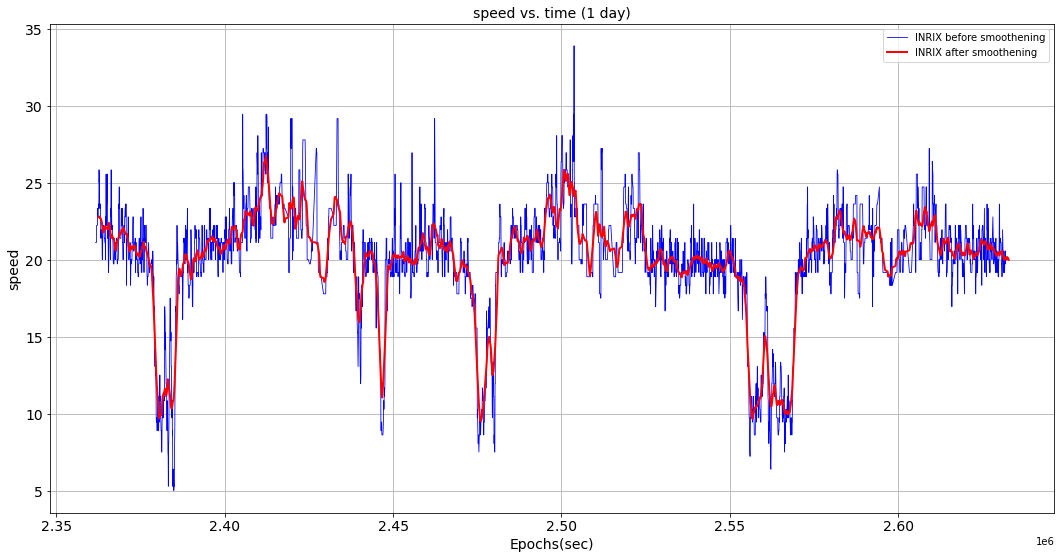

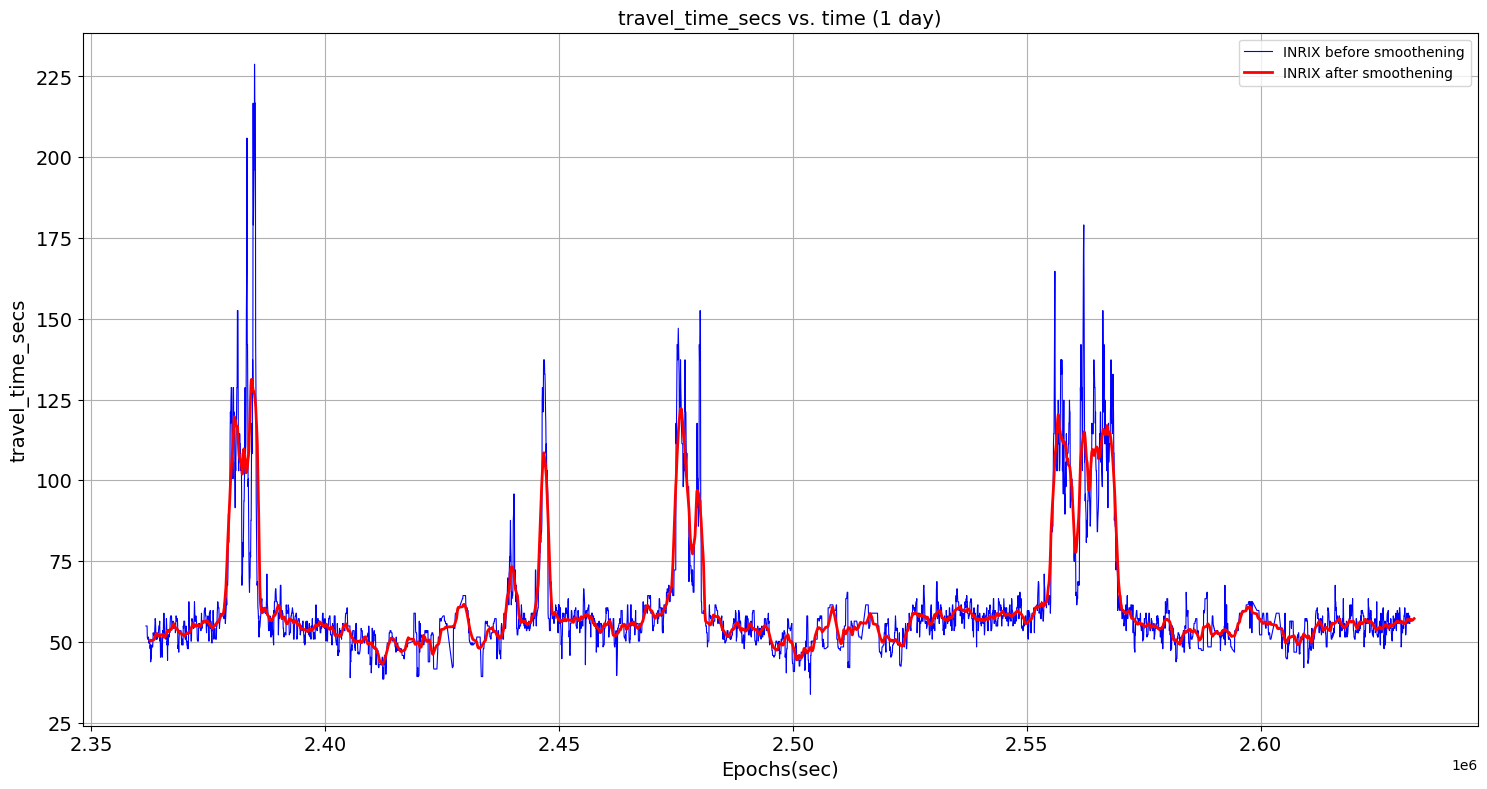

In [ ]:
# Plot original speed and smoothened speed for INRIX
plt.figure(figsize=(18, 9))
plotAttr2DF(1, inrixSouth_removed.iloc[1440*26:1440*29], inrixSouth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'speed', 'INRIX before smoothening', 'INRIX after smoothening')

# Plot original travel time and smoothened one for INRIX
plt.figure(figsize=(18, 9))
plotAttr2DF(1, inrixSouth_removed.iloc[1440*26:1440*29], inrixSouth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX before smoothening', 'INRIX after smoothening')

# 3. Explore and Pre-process MCS data

# 3.1 Check distribution of speed and flow

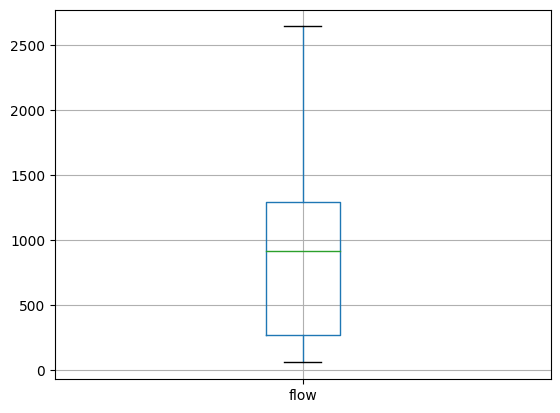

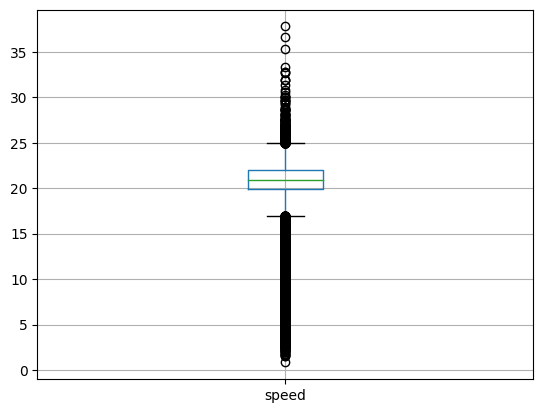

In [ ]:
#check the distribution of MCS speed and flow
# check is there any outlier needs to be filtered
mcsSouth = mcsSouth_raw.copy()

plt.style.use('default')
plt.figure(1)
boxplot1 = mcsSouth.boxplot(column=['flow'])

plt.figure(2)
boxplot2 = mcsSouth.boxplot(column=['speed']) 

## 3.2 Convert to Datetime & Calculate the Epoch

In [ ]:
print(mcsSouth.head(10))
mcsSouth.info()

   fk_id                 date    speed  ...    used_lanes  Epoch_mcs   Density
0   1162  2018-10-01 00:00:00  23.1675  ...  {1,1,1,NULL}        0.0  0.158268
1   1162  2018-10-01 00:01:00  21.5449  ...  {1,1,1,NULL}       60.0  0.077358
2   1162  2018-10-01 00:02:00  24.2640  ...  {1,1,1,NULL}      120.0  0.137378
3   1162  2018-10-01 00:03:00  22.5872  ...  {1,1,1,NULL}      180.0  0.132819
4   1162  2018-10-01 00:04:00  22.7721  ...  {1,1,1,NULL}      240.0  0.204929
5   1162  2018-10-01 00:05:00  23.9467  ...  {1,1,1,NULL}      300.0  0.139198
6   1162  2018-10-01 00:06:00  23.4330  ...  {1,1,1,NULL}      360.0  0.142250
7   1162  2018-10-01 00:07:00  23.9433  ...  {1,1,1,NULL}      420.0  0.139218
8   1162  2018-10-01 00:08:00  22.5018  ...  {1,1,1,NULL}      480.0  0.118509
9   1162  2018-10-01 00:09:00  25.0348  ...  {1,1,1,NULL}      540.0  0.106518

[10 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):


In [ ]:
# convert column "date" into Datetime objects, add back into original column "date"
convertToDateD = lambda row: datetime.strptime(row['date'], "%Y-%m-%d %H:%M:%S")
mcsSouth['date'] = mcsSouth.apply(convertToDateD, axis=1)

# check the datatype after convertion
print(mcsSouth.info())
mcsSouth.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fk_id          44275 non-null  int64         
 1   date           44275 non-null  datetime64[ns]
 2   speed          44275 non-null  float64       
 3   speed_std_dev  44275 non-null  float64       
 4   flow           44275 non-null  int64         
 5   used_lanes     44275 non-null  object        
 6   Epoch_mcs      44275 non-null  float64       
 7   Density        44275 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 2.7+ MB
None


fk_id                date    speed  ...    used_lanes  Epoch_mcs   Density
0   1162 2018-10-01 00:00:00  23.1675  ...  {1,1,1,NULL}        0.0  0.158268
1   1162 2018-10-01 00:01:00  21.5449  ...  {1,1,1,NULL}       60.0  0.077358
2   1162 2018-10-01 00:02:00  24.2640  ...  {1,1,1,NULL}      120.0  0.137378
3   1162 2018-10-01 00:03:00  22.5872  ...  {1,1,1,NULL}      180.0  0.132819
4   1162 2018-10-01 00:04:00  22.7721  ...  {1,1,1,NULL}      240.0  0.204929
5   1162 2018-10-01 00:05:00  23.9467  ...  {1,1,1,NULL}      300.0  0.139198
6   1162 2018-10-01 00:06:00  23.4330  ...  {1,1,1,NULL}      360.0  0.142250
7   1162 2018-10-01 00:07:00  23.9433  ...  {1,1,1,NULL}      420.0  0.139218
8   1162 2018-10-01 00:08:00  22.5018  ...  {1,1,1,NULL}      480.0  0.118509
9   1162 2018-10-01 00:09:00  25.0348  ...  {1,1,1,NULL}      540.0  0.106518

[10 rows x 8 columns]

In [ ]:
# calculate the Epoch according to the date
mcsSouth['Epoch_test'] = 0.0

for i in range(len(mcsSouth)):
  mcsSouth.at[i, 'Epoch_test'] = calEpoch(mcsSouth, 'date', i)

mcsSouth.iloc[idx(mcsSouth,28)+140:idx(mcsSouth, 28) + 150]

fk_id                date    speed  ...  Epoch_mcs   Density Epoch_test
38710   1162 2018-10-28 02:20:00  21.2048  ...  2341200.0  0.106108  2341200.0
38711   1162 2018-10-28 02:21:00  24.2565  ...  2341260.0  0.151162  2341260.0
38712   1162 2018-10-28 02:22:00  22.5899  ...  2341320.0  0.206582  2341320.0
38713   1162 2018-10-28 02:23:00  23.1053  ...  2341380.0  0.173120  2341380.0
38714   1162 2018-10-28 02:24:00  20.8489  ...  2341440.0  0.239821  2341440.0
38715   1162 2018-10-28 02:25:00  23.5543  ...  2341500.0  0.127365  2341500.0
38716   1162 2018-10-28 02:26:00  22.3846  ...  2345160.0  0.189863  2341560.0
38717   1162 2018-10-28 02:27:00  23.0723  ...  2345220.0  0.202263  2341620.0
38718   1162 2018-10-28 02:28:00  22.8486  ...  2345280.0  0.116710  2341680.0
38719   1162 2018-10-28 02:29:00  23.0519  ...  2345340.0  0.187982  2341740.0

[10 rows x 9 columns]

In [ ]:
# assign the new epoch to 'Epoch_mcs', drop the test epoch column
mcsSouth.Epoch_mcs = mcsSouth.Epoch_test
mcsSouth.drop(columns='Epoch_test', inplace=True)
mcsSouth

fk_id                date    speed  ...       used_lanes  Epoch_mcs   Density
0       1162 2018-10-01 00:00:00  23.1675  ...     {1,1,1,NULL}        0.0  0.158268
1       1162 2018-10-01 00:01:00  21.5449  ...     {1,1,1,NULL}       60.0  0.077358
2       1162 2018-10-01 00:02:00  24.2640  ...     {1,1,1,NULL}      120.0  0.137378
3       1162 2018-10-01 00:03:00  22.5872  ...     {1,1,1,NULL}      180.0  0.132819
4       1162 2018-10-01 00:04:00  22.7721  ...     {1,1,1,NULL}      240.0  0.204929
...      ...                 ...      ...  ...              ...        ...       ...
44270   1162 2018-10-31 23:50:00  21.6036  ...     {1,1,1,NULL}  2677800.0  0.092577
44271   1162 2018-10-31 23:51:00  23.6255  ...        {1,1,1,1}  2677860.0  0.201054
44272   1162 2018-10-31 23:52:00  21.2808  ...  {1,1,NULL,NULL}  2677920.0  0.305440
44273   1162 2018-10-31 23:53:00  20.6412  ...     {1,1,1,NULL}  2677980.0  0.145340
44274   1162 2018-10-31 23:54:00  23.4714  ...  {1,1,NULL,NULL}  2678040.0  0.085210

[44275 rows x 8 columns]

## 3.3 Smoothen MCS Speed and Flow

In [ ]:
# smoothen the speed column by centered moving average
rolling_speed = mcsSouth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
44270   NaN
44271   NaN
44272   NaN
44273   NaN
44274   NaN
Name: speed, Length: 44275, dtype: float64

In [ ]:
# smoothen the flow column by centered moving average
rolling_flow = mcsSouth.flow.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_flow = rolling_flow.mean()
rolling_mean_flow

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
44270   NaN
44271   NaN
44272   NaN
44273   NaN
44274   NaN
Name: flow, Length: 44275, dtype: float64

In [ ]:
# add the smoothened columns back to the datafram
mcsSouth_MA = mcsSouth.copy()
mcsSouth_MA.speed = rolling_mean_speed
mcsSouth_MA.flow = rolling_mean_flow
mcsSouth_MA

fk_id                date  speed  ...       used_lanes  Epoch_mcs   Density
0       1162 2018-10-01 00:00:00    NaN  ...     {1,1,1,NULL}        0.0  0.158268
1       1162 2018-10-01 00:01:00    NaN  ...     {1,1,1,NULL}       60.0  0.077358
2       1162 2018-10-01 00:02:00    NaN  ...     {1,1,1,NULL}      120.0  0.137378
3       1162 2018-10-01 00:03:00    NaN  ...     {1,1,1,NULL}      180.0  0.132819
4       1162 2018-10-01 00:04:00    NaN  ...     {1,1,1,NULL}      240.0  0.204929
...      ...                 ...    ...  ...              ...        ...       ...
44270   1162 2018-10-31 23:50:00    NaN  ...     {1,1,1,NULL}  2677800.0  0.092577
44271   1162 2018-10-31 23:51:00    NaN  ...        {1,1,1,1}  2677860.0  0.201054
44272   1162 2018-10-31 23:52:00    NaN  ...  {1,1,NULL,NULL}  2677920.0  0.305440
44273   1162 2018-10-31 23:53:00    NaN  ...     {1,1,1,NULL}  2677980.0  0.145340
44274   1162 2018-10-31 23:54:00    NaN  ...  {1,1,NULL,NULL}  2678040.0  0.085210

[44275 rows x 8 columns]

In [ ]:
# remove the rows with NaN value due to the moving average process
mcsSouth_MA = mcsSouth_MA.dropna()
mcsSouth_MA.reset_index(inplace=True, drop=True)
mcsSouth_MA

fk_id                date  ...  Epoch_mcs   Density
0       1162 2018-10-01 00:15:00  ...      900.0  0.106837
1       1162 2018-10-01 00:16:00  ...      960.0  0.147015
2       1162 2018-10-01 00:17:00  ...     1020.0  0.148958
3       1162 2018-10-01 00:18:00  ...     1080.0  0.077900
4       1162 2018-10-01 00:19:00  ...     1140.0  0.174209
...      ...                 ...  ...        ...       ...
44241   1162 2018-10-31 23:36:00  ...  2676960.0  0.111295
44242   1162 2018-10-31 23:37:00  ...  2677020.0  0.237740
44243   1162 2018-10-31 23:38:00  ...  2677080.0  0.143865
44244   1162 2018-10-31 23:39:00  ...  2677140.0  0.216583
44245   1162 2018-10-31 23:40:00  ...  2677200.0  0.203737

[44246 rows x 8 columns]

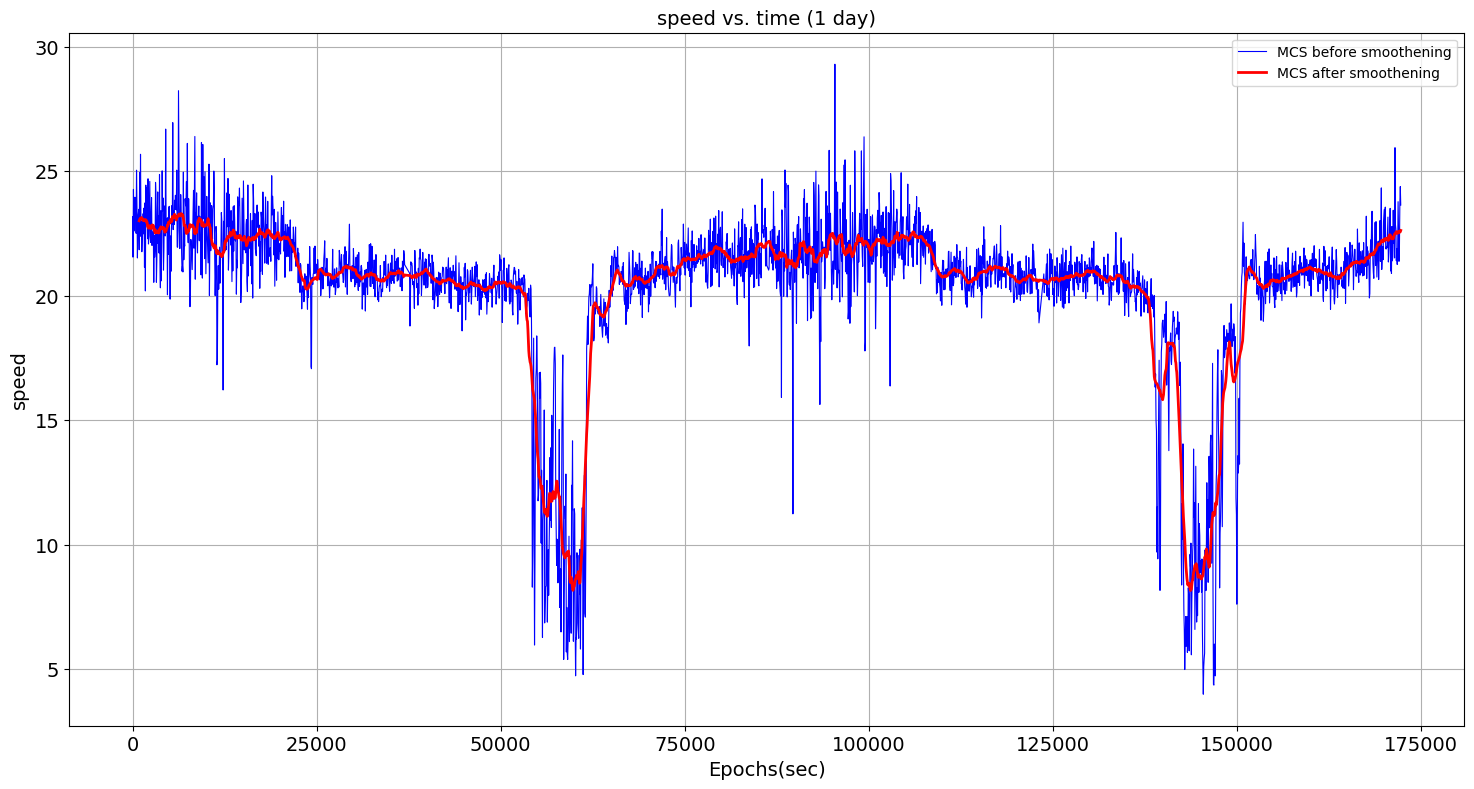

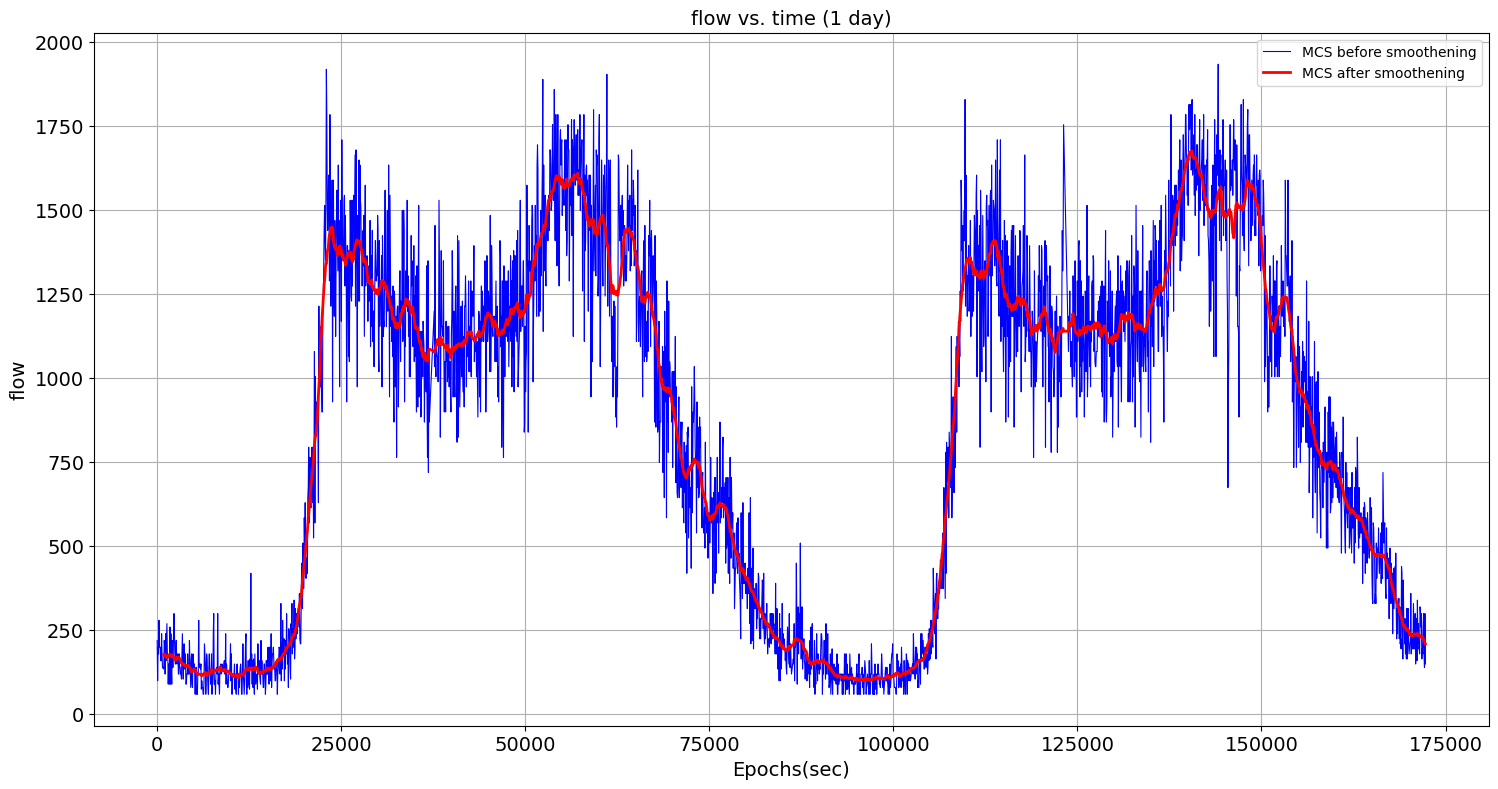

In [ ]:
# Plot original speed and smoothened speed for MCS
plt.figure(figsize=(18, 9))
plotAttr2DF(1, mcsSouth.iloc[:idx(mcsSouth, 3)], mcsSouth_MA.iloc[:idx(mcsSouth_MA, 3)], 
            'Epoch_mcs', 'speed', 'MCS before smoothening', 'MCS after smoothening')

# Plot original flow and smoothened flow for MCS
plt.figure(figsize=(18, 9))
plotAttr2DF(1, mcsSouth.iloc[:idx(mcsSouth, 3)], mcsSouth_MA.iloc[:idx(mcsSouth_MA, 3)], 
            'Epoch_mcs', 'flow', 'MCS before smoothening', 'MCS after smoothening')

# 4. Pre-process(Combine) both MCS and INRIX dataframes

*  Match the corresponding timesteps between MCS and INRIX

## 4.1 Shift the time-lag of INRIX South

In [ ]:
# Shift Epoch_inrix of INRIX south by adding 114 mins in order to eliminate the time-gap  
inrixSouth_shifted = inrixSouth_MA.copy()
print(inrixSouth_shifted)
inrixSouth_shifted['Epoch_inrix'] = inrixSouth_shifted.Epoch_inrix + (114 * 60)
print(inrixSouth_shifted)

        segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11        899.0
1      1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09        957.0
2      1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       1022.0
3      1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       1076.0
4      1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       1137.0
...           ...                 ...  ...                 ...          ...
42498  1071883675 2018-10-31 23:41:08  ... 2018-11-01 00:41:08    2677256.0
42499  1071883675 2018-10-31 23:42:09  ... 2018-11-01 00:42:09    2677317.0
42500  1071883675 2018-10-31 23:43:08  ... 2018-11-01 00:43:08    2677376.0
42501  1071883675 2018-10-31 23:44:09  ... 2018-11-01 00:44:08    2677437.0
42502  1071883675 2018-10-31 23:45:15  ... 2018-11-01 00:45:15    2677503.0

[42503 rows x 10 columns]
        segmentid        timestamputc  ...          date_inri

## 4.2 Match the MCS and INRIX data rows in the same timesteps


In [ ]:
# function to match inrix timesteps to mcs, and merge them
# Input: mcs dataframe, inrix dataframe
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStep (mcsDf, inrixDf):
  DELTATIME = 26.0
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0
  j = 0
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix']
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < DELTATIME ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1
      j += 1
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1
      print('missing mcs', j)
    elif ((inrixEpoch -mcsEpoch) > 0.0):
      i +=1
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  inrixMatched.rename(columns = {'speed': 'speed_inrix'}, inplace = True)
  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined df:', len(combinedDf))
  
  return combinedDf
  

In [ ]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for progress monitoring 
combinedSouth_shifted = matchTimeStep(mcsSouth_MA, inrixSouth_shifted)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, reference, score, cvalue, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missin

In [ ]:
combinedSouth_shifted[['date', 'speed', 'Epoch_mcs', 'timestamputc', 'speed_inrix', 'Epoch_inrix']]

date      speed  ...  speed_inrix Epoch_inrix
0     2018-10-01 02:09:00  22.745083  ...    21.490741      7739.0
1     2018-10-01 02:10:00  22.850957  ...    21.268519      7797.0
2     2018-10-01 02:11:00  22.758003  ...    21.046296      7862.0
3     2018-10-01 02:12:00  22.767160  ...    20.787037      7916.0
4     2018-10-01 02:13:00  22.799650  ...    20.527778      7977.0
...                   ...        ...  ...          ...         ...
42050 2018-10-31 23:36:00  22.148783  ...    20.953704   2676958.0
42051 2018-10-31 23:37:00  22.182707  ...    20.879630   2677016.0
42052 2018-10-31 23:38:00  22.168527  ...    20.796296   2677076.0
42053 2018-10-31 23:39:00  22.116450  ...    20.712963   2677139.0
42054 2018-10-31 23:40:00  22.180113  ...    20.712963   2677197.0

[42055 rows x 6 columns]

In [ ]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth_shifted.info())
print(mcsSouth_MA.info())
print(inrixSouth_shifted.info())
combinedSouth_shifted = combinedSouth_shifted.astype({'fk_id':'int64', 'flow':'int64', 
                                                      'segmentid':'int64', 'Epoch_inrix':'int64', 
                                                      'score': 'int64', 'cvalue': 'int64'})
combinedSouth_shifted.info()
combinedSouth_shifted.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42055 entries, 0 to 42054
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             42055 non-null  int64         
 1   date              42055 non-null  datetime64[ns]
 2   speed             42055 non-null  float64       
 3   speed_std_dev     42055 non-null  float64       
 4   flow              42055 non-null  int64         
 5   used_lanes        42055 non-null  object        
 6   Epoch_mcs         42055 non-null  float64       
 7   Density           42055 non-null  float64       
 8   segmentid         42055 non-null  int64         
 9   timestamputc      42055 non-null  datetime64[ns]
 10  speed_inrix       42055 non-null  float64       
 11  average           42055 non-null  float64       
 12  reference         42055 non-null  float64       
 13  score             42055 non-null  int64         
 14  cvalue            4205

fk_id                date  ...          date_inrix  Epoch_inrix
0   1162 2018-10-01 02:09:00  ... 2018-10-01 02:15:11         7739
1   1162 2018-10-01 02:10:00  ... 2018-10-01 02:16:09         7797
2   1162 2018-10-01 02:11:00  ... 2018-10-01 02:17:14         7862

[3 rows x 18 columns]

In [ ]:
# save the processed dataframe into the directory
combinedSouth_shifted.to_pickle('OutData/inrixMcsSouth.pkl')

## 4.3 Data exploration after smoothening, data-steps shifting and matching




In [ ]:
combinedSouth_shifted.describe()

fk_id         speed  ...  travel_time_secs   Epoch_inrix
count  42055.0  42055.000000  ...      42055.000000  4.205500e+04
mean    1162.0     20.235720  ...         58.751047  1.341615e+06
std        0.0      3.017217  ...         16.575416  7.703173e+05
min     1162.0      2.350398  ...         39.654000  7.739000e+03
25%     1162.0     20.122197  ...         51.711000  6.725125e+05
50%     1162.0     20.853607  ...         54.260000  1.340576e+06
75%     1162.0     21.995122  ...         56.822000  2.010686e+06
max     1162.0     24.014040  ...        243.594000  2.677197e+06

[8 rows x 14 columns]

In [ ]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plot2Attr(days, dataFrame, attribute1, attribute2, location):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r',linewidth = 1.2, label = 'mcs_' + location)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 1.2, label = 'inrix_' + location)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute1, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute1 + ' vs. time (' + str(days) + ' )', fontsize = 14)
  plt.legend()
  plt.show()

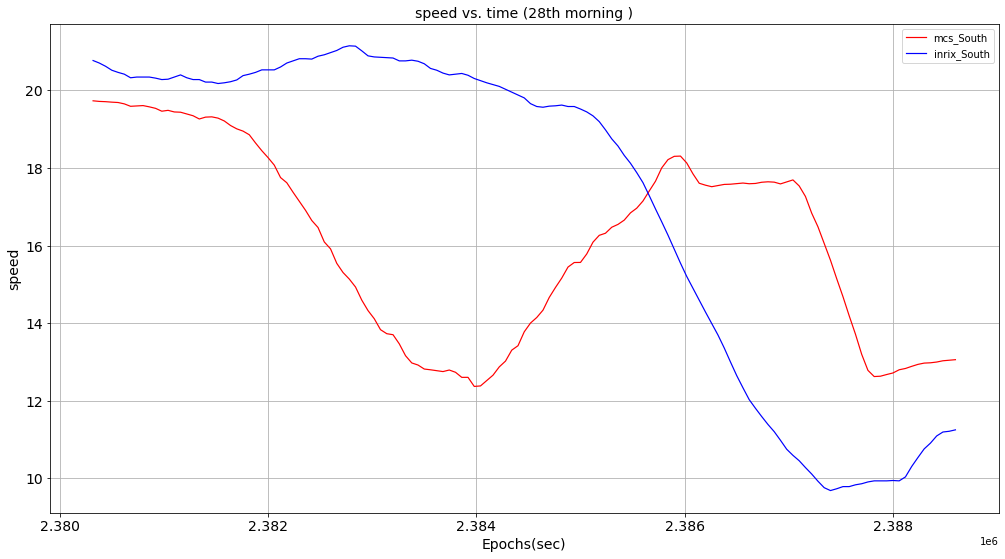

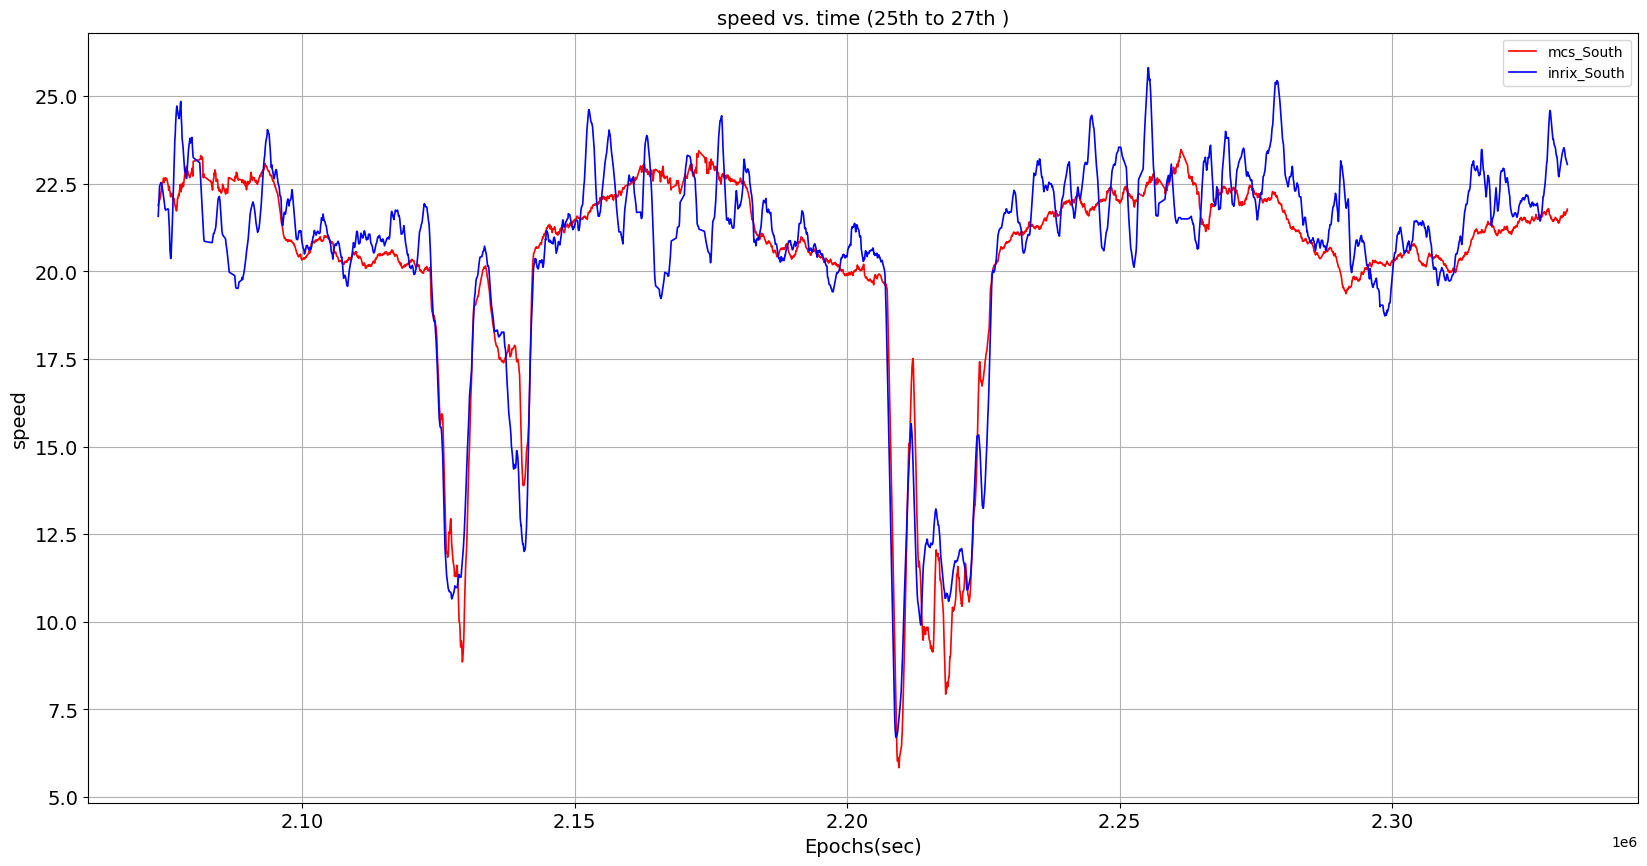

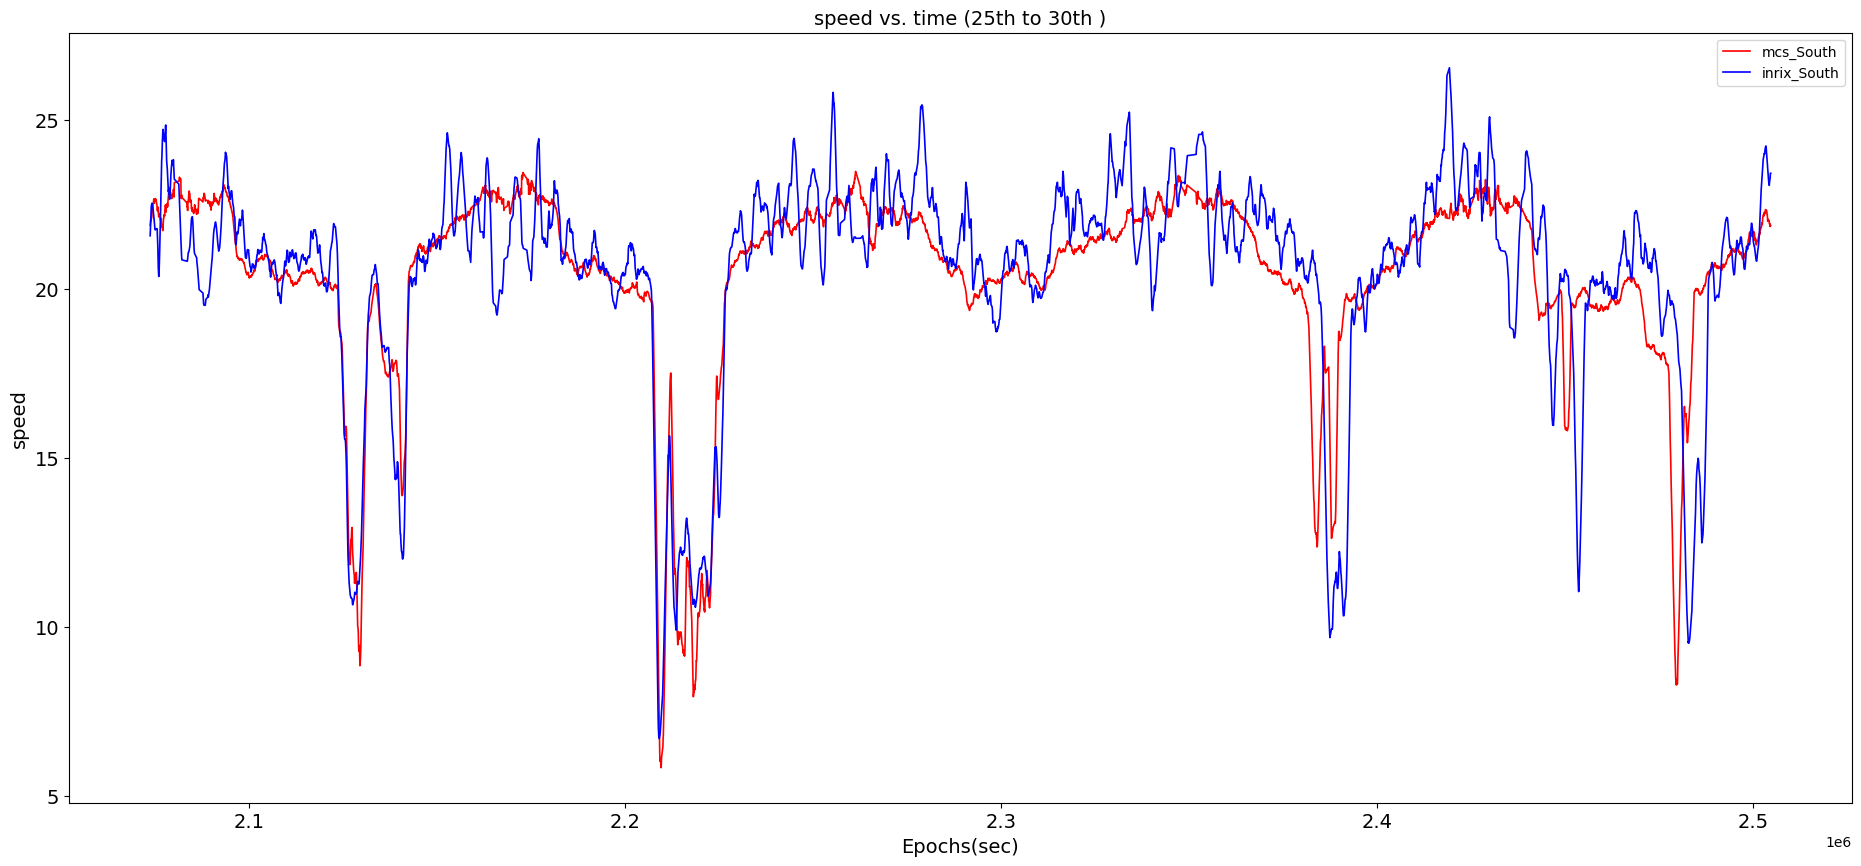

In [ ]:
combinedSouthT_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 28) + 700: idx(combinedSouth_shifted, 29) - 500] 
plt.figure(figsize=(17, 9))
plt.grid()
plot2Attr('28th morning', combinedSouthT_shifted, 'speed', 'speed_inrix', 'South')

plt.figure(figsize=(20, 10))
combinedSouthT2_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 25) :idx(combinedSouth_shifted, 28)]
plt.grid()
plot2Attr('25th to 27th', combinedSouthT2_shifted, 'speed', 'speed_inrix', 'South')

plt.figure(figsize=(23, 10))
combinedSouthT3_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 25) :idx(combinedSouth_shifted, 30)]
plot2Attr('25th to 30th', combinedSouthT3_shifted, 'speed', 'speed_inrix', 'South')

In [ ]:
def plotScatter(data1, data2, attribute1, attribute2, Label):
  plt.scatter(data1[attribute1], data2[attribute2], s=1.5, label=Label)
  plt.xlabel(attribute1, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2, fontsize = 15)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 20)
  plt.legend()
  plt.show()

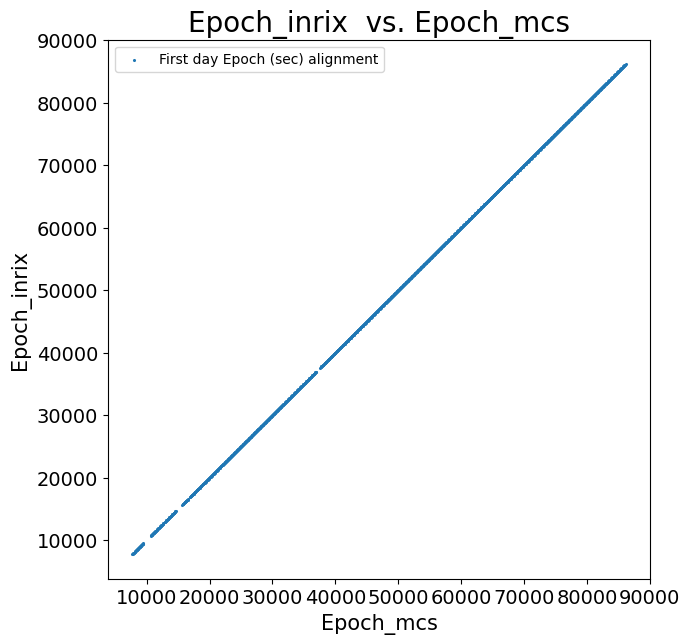

In [ ]:
# draw plot of epoch_mcs vs. epoch_inrix after shifting
plt.figure(figsize = (7, 7))
combinedSouth1day_shifted = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 2)]
plotScatter(combinedSouth1day_shifted, combinedSouth1day_shifted, 'Epoch_mcs', 'Epoch_inrix','First day Epoch (sec) alignment')

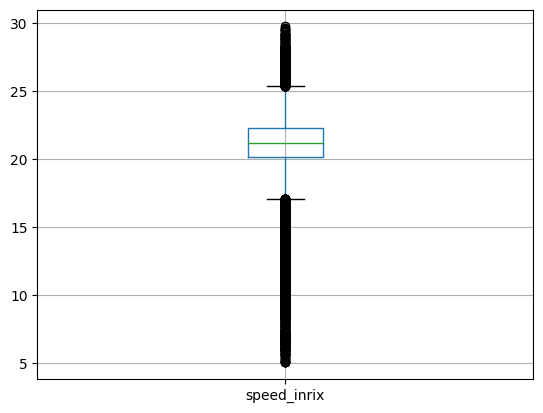

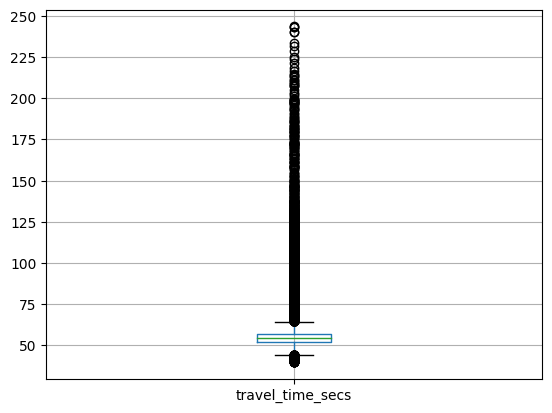

In [ ]:
# check distribution of speed_inrix and tracel_time_secs after remove low score data and match the timesteps among MCS and INRIX

plt.figure(1)
boxplot = combinedSouth_shifted.boxplot(column=['speed_inrix'])

plt.figure(2)
boxplot = combinedSouth_shifted.boxplot(column=['travel_time_secs'])

             speed_inrix     speed
speed_inrix     1.000000  0.904243
speed           0.904243  1.000000


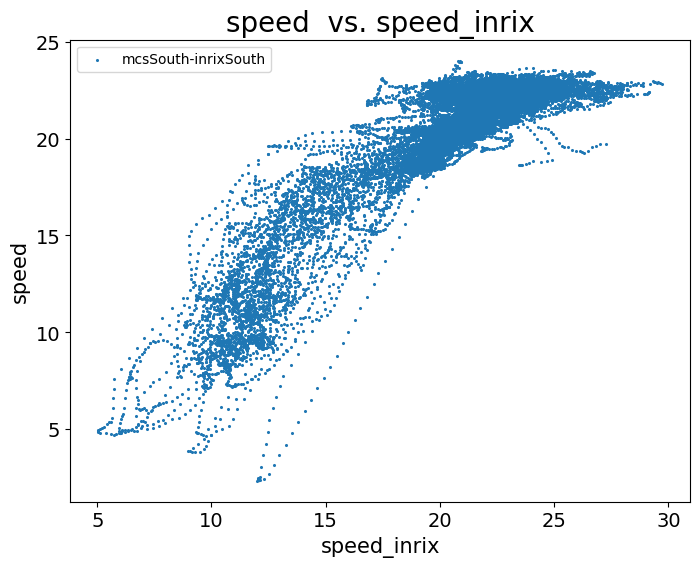

In [ ]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

             speed_inrix      flow
speed_inrix     1.000000 -0.598008
flow           -0.598008  1.000000


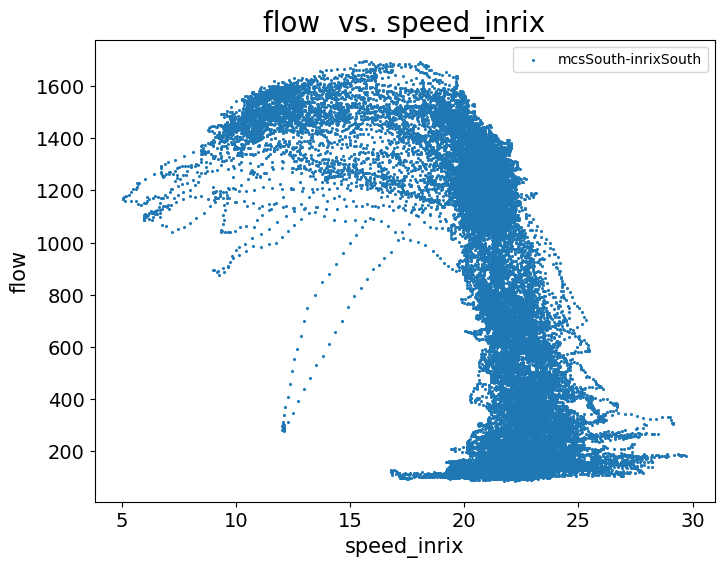

In [ ]:
# draw flow_mcs vs. Speed_inrix after time step matched
combinedCorr2 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix', 'flow']].copy() # until 27th Oct
print(combinedCorr2.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'mcsSouth-inrixSouth')

          speed      flow
speed  1.000000 -0.615695
flow  -0.615695  1.000000


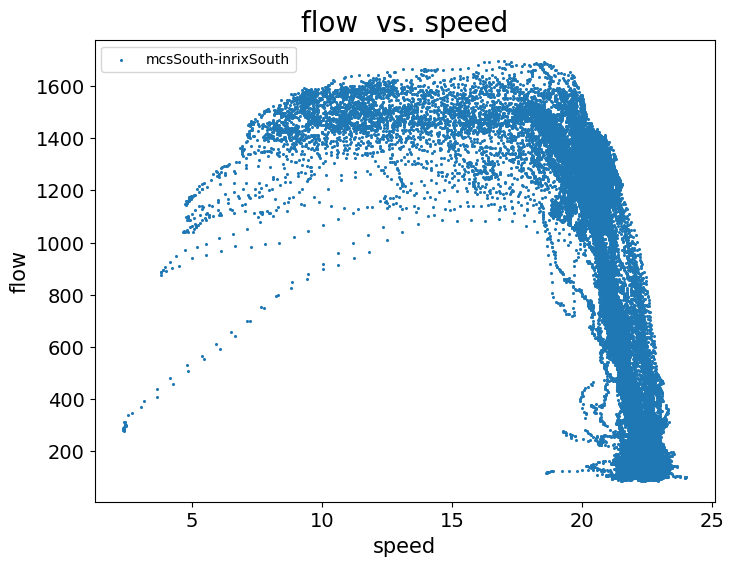

In [ ]:
# draw flow_mcs vs. Speed_mcs after time step matched
combinedCorr3 = combinedSouth_shifted.iloc[:][['speed', 'flow']].copy()
print(combinedCorr3.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr3, combinedCorr3, 'speed', 'flow', 'mcsSouth-inrixSouth')

      need to change the model building in following sections

# 5. Linear (Polynomial) Regression Models
  Use linear (polynomial) regression model to capture the relation between speed/travel time and MCS flow/denstiy

*   Ground Truth Model: Mcs speed -> Mcs Flow ( or Density)
*   INRIX speed -> MCS Flow



In [ ]:
# load the combined/processed dataframe
# start from this cell if data frame has been processed before
combinedSouth_shifted = pd.read_pickle('OutData/inrixMcsSouth.pkl')

## 5.0 helper function to plot fitting results

In [ ]:
# function to plot the predicted value and real label value according to training/testing dataset
def plotResult(xTrain, yTrain, yPredTrain, xTest, yTest, yPredTest, timeRange, xLabel, yLabel, plotStyle = 's'):
  plt.style.use('default')
  if (xTest is not None):
    plt.scatter(xTrain, yTrain, s=3, color='black', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 25, color='blue', marker = "s", label='predicted flow(train_set)')
    plt.scatter(xTest, yTest, color='red', s=3, label='real flow(test_set)')
    plt.scatter(xTest, yPredTest, color='green', s=25, marker = 's', label='predicted flow(test_set)')
  elif (plotStyle == 'p'):
    plt.plot(xTrain, yPredTrain, linewidth=1.5, color='blue', linestyle = 'dashed', mfc='none',  label='predicted flow', zorder= 0, marker='o')
    plt.scatter(xTrain, yTrain, s=3, color='red', label='real flow', zorder= 10)
  elif (plotStyle == 's'):
    plt.scatter(xTrain, yTrain, s = 3, color='green', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 15, color='red', marker = "s", facecolors='none', label='predicted flow(train_set)')
    
  plt.xlabel(xLabel, fontsize= 20) 
  plt.xticks(fontsize = 15)
  plt.ylabel(yLabel, fontsize=20)
  plt.yticks(fontsize = 15)
  plt.title('Regression model for estimation of ' + yLabel + ' in ' + timeRange, fontsize= 14)
  plt.legend(fontsize=14)
  plt.show()

## 5.1 Reference linear regression model: MCS Speed -> MCS FLow

In [ ]:
# function for turning single feature into polynomial feature columns 
# Input X: numpy array with shape(sample number, )
# Output X_poly: numpy array with shape(sample #, polynomial degree + 1)
def makePoly(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_1 = X.reshape(-1, 1)
  X_poly = poly.fit_transform(X_1)
  return X_poly

In [ ]:
# funtion for normalizing the feature columns
# Input: X: Numpy array with shape(sample #, polynomial degree + 1)
# Output X_scaled: normalized Numpy array with shape(sample #, polynomial degree + 1)
# Output scaler: scaler, which fitted on input array, for normalization
def normalize(X, Scaler=None):
  # remove the bias column
  X_1 = np.delete(X, 0, 1)

  # scale the remaining feature columns
  scaler = None
  X_2 = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_2 = scaler.fit_transform(X_1)
  else:
    scaler = Scaler
    X_2 = scaler.transform(X_1)

  # add the bias column back to the features columns
  ones = np.ones((len(X_2), 1))
  X_scaled = np.append(ones, X_2, 1)
  
  return X_scaled, scaler

In [ ]:
# function to build and fit linear model on input arrays
def LRmodel(X_train, Y_train):
  regressor = LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)
  return regressor

In [ ]:
# function used to print the cross-validation scores on training set
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean()) 
  print("Standard deviation:", scores.std())

In [ ]:
# select 2 weeks data to build model
combinedSouth_2w = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 22)]

# prepare the feature "MCS speed"
X_epoch = combinedSouth_2w['Epoch_mcs'].values
X_mcs_speed = combinedSouth_2w['speed'].values
Y_flow = combinedSouth_2w['flow'].values

# turn single feature into polynomial features matrix: 1, s, s^2, s^3, ...
X_mcs_speed = makePoly(4, X_mcs_speed)
X_mcs_speed, scaler_mcs_speed = normalize(X_mcs_speed)


# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_mcs_speed)
dfRawFeatures.describe()

0             1             2             3             4
count  28576.0  2.857600e+04  2.857600e+04  2.857600e+04  2.857600e+04
mean       1.0 -2.239741e-14  3.647925e-14  9.753284e-15  7.235774e-15
std        0.0  1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00
min        1.0 -6.125217e+00 -4.321398e+00 -3.460750e+00 -2.956169e+00
25%        1.0 -3.395796e-02 -1.314161e-01 -2.261566e-01 -3.127241e-01
50%        1.0  1.895440e-01  1.485723e-01  9.942340e-02  4.736325e-02
75%        1.0  5.692259e-01  6.446986e-01  7.012682e-01  7.418598e-01
max        1.0  1.075050e+00  1.345720e+00  1.603336e+00  1.846186e+00

In [ ]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_mcs_speed
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [ ]:
# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(LinearRegression(fit_intercept=False), X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

Scores: [0.80682409 0.7939979  0.80829938 0.80432575 0.80552962 0.81651153
 0.8228369  0.80811519 0.81413923 0.8053862 ]
Mean: 0.8085965792784375
Standard deviation: 0.007420850229688083


In [ ]:
# Build the regression model fitted on train dataset
regressor = LRmodel(X_train, Y_train)
regressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  215.60802520090056
R2 Score for training set:  0.808692027653148
Root Mean Square Error:  214.71584770470793
R2 Score:  0.809193799873542


  R2 experiments:
  * d = 2 (0.71)
  * d = 3 (0.53, 0.533) 
  * d = 4 (0.80)
  * d = 5 (0.81)
  * d = 6 (0.83)



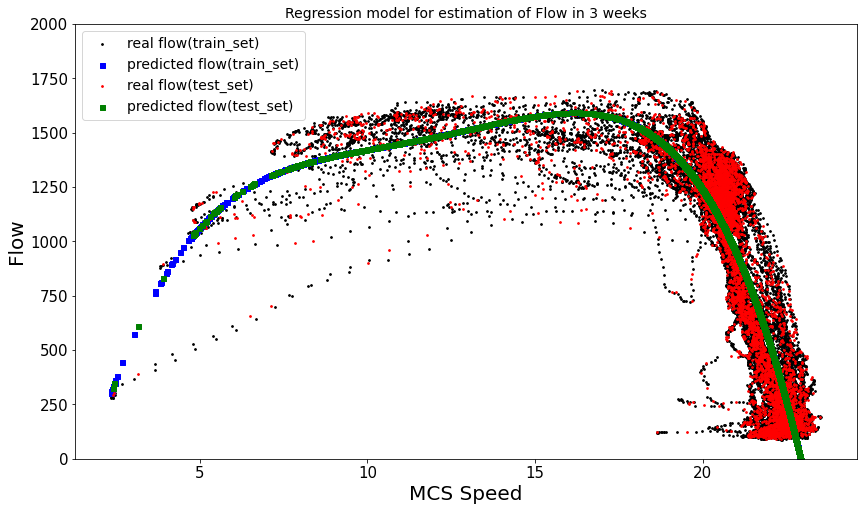

In [ ]:
# Plot real and predicted flow for X_train, X_test
X_train_denormalized = scaler_mcs_speed.inverse_transform(X_train[:,1:])
X_test_denormalized = scaler_mcs_speed.inverse_transform(X_test[:, 1:])
plt.figure(figsize=(14, 8))
plt.ylim(top = 2000)
#plt.xlim(left=-7, right = 2)
plotResult(X_train_denormalized[:, 0], Y_train, Y_predict_train, 
           X_test_denormalized[:, 0], Y_test, Y_predict_test, '3 weeks', 'MCS Speed', 'Flow')

In [ ]:
# Use all data to train and predict the flow
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  215.4298603437973
R2 Score:  0.8087922009914518


In [ ]:
print(Y_label.shape)

(28576,)


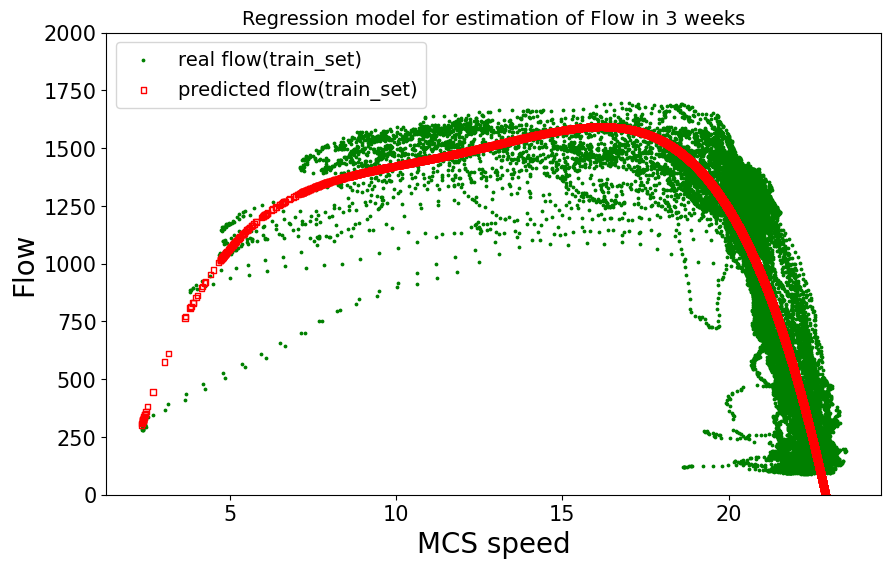

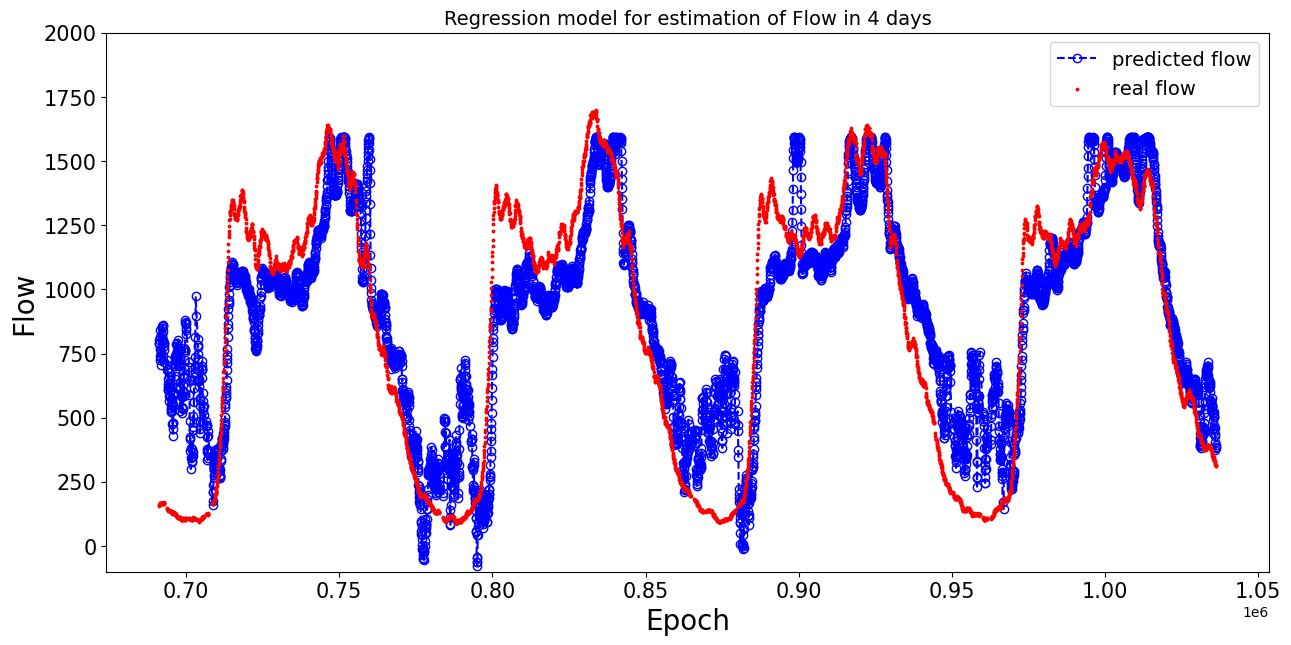

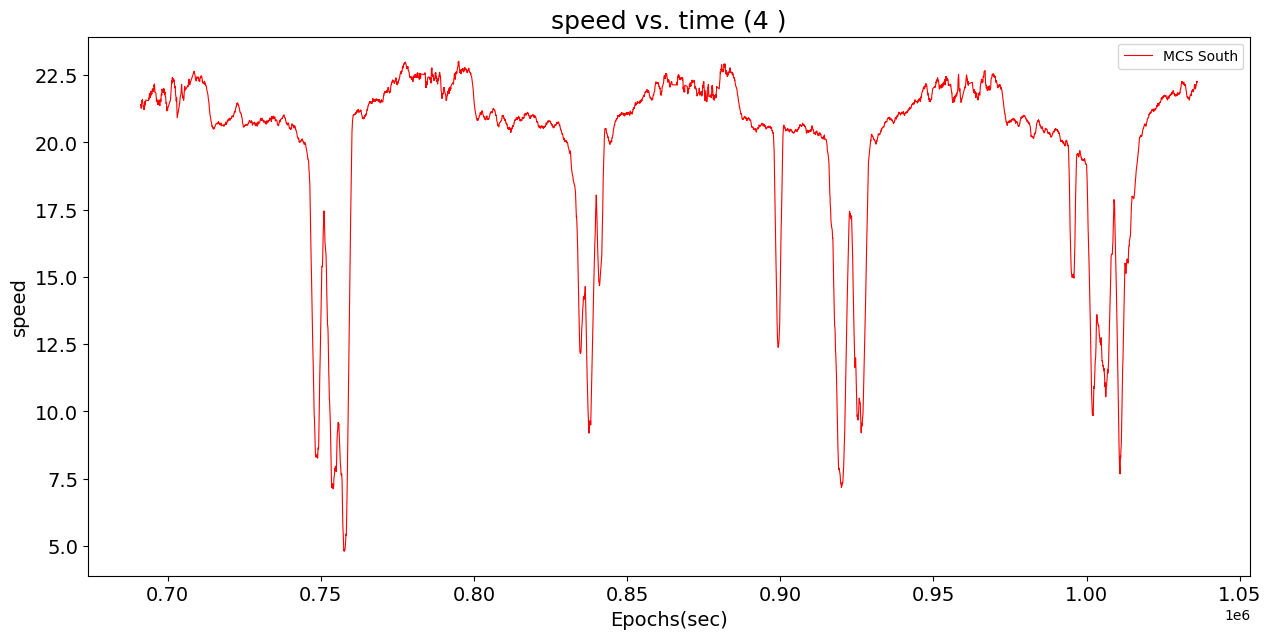

In [ ]:
# Plot real and predicted flow vs. X_features (speed_mcs)
X_features_mcs_denormalized = scaler_mcs_speed.inverse_transform(X_features[:,1:])
plt.figure(figsize=(10, 6))
plt.ylim(bottom = 0, top=2000)
# plotResult(X_features_mcs_denormalized[idx(combinedSouth_2w, 8): idx(combinedSouth_2w, 9), 0], 
#            Y_label[idx(combinedSouth_2w, 8): idx(combinedSouth_2w, 9)], 
#            Y_predict[idx(combinedSouth_2w, 8): idx(combinedSouth_2w, 9)], 
#            None,  None, None, '3 weeks', 'MCS speed', 'Flow')

plotResult(X_features_mcs_denormalized[:, 0], Y_label, Y_predict, 
           None,  None, None, '3 weeks', 'MCS speed', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(15, 7))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(15, 7))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed', 'MCS South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

## 5.2 Linear regression model: INRIX Speed -> MCS Flow

In [ ]:
# prepare the feature "INRIX speed"
X_inrix_speed = combinedSouth_2w['speed_inrix'].values
Y_flow = combinedSouth_2w['flow'].values

# turn single feature into polynomial features matrix: 1, s, s^2, s^3, ...
X_inrix_speed = makePoly(5, X_inrix_speed)
X_inrix_speed, scaler_inrix_speed = normalize(X_inrix_speed)


# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_inrix_speed)
dfRawFeatures.describe()

0             1  ...             4             5
count  28576.0  2.857600e+04  ...  2.857600e+04  2.857600e+04
mean       1.0 -2.579683e-15  ...  1.072135e-14 -2.052988e-15
std        0.0  1.000017e+00  ...  1.000017e+00  1.000017e+00
min        1.0 -4.831781e+00  ... -2.219691e+00 -1.838199e+00
25%        1.0 -1.310572e-01  ... -4.039483e-01 -4.539162e-01
50%        1.0  1.488157e-01  ... -5.529921e-02 -1.150484e-01
75%        1.0  5.029407e-01  ...  4.548440e-01  4.054658e-01
max        1.0  2.779050e+00  ...  6.171232e+00  7.513501e+00

[8 rows x 6 columns]

In [ ]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_inrix_speed
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [ ]:
# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(LinearRegression(fit_intercept=False), X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

Scores: [0.49210233 0.48827144 0.49464933 0.46851642 0.4821314  0.49827394
 0.48869447 0.48130516 0.5058485  0.50086415]
Mean: 0.4900657135045988
Standard deviation: 0.010331540279117013


In [ ]:
# Build the regression model fitted on whole train dataset
regressor = LRmodel(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  351.89240387911565
R2 Score for training set:  0.4904075215980265
Root Mean Square Error:  351.2860592638399
R2 Score:  0.48927618047674426


    R2 Experiment(10-folds cross validation on train dataset):
    * d = 2: 
    * d = 3: 0.45
    * d = 4: 0.477
    * d = 5: 0.49
    * d = 6: 0.48
    * d = 7: 0.49
    * d = 8: 

  

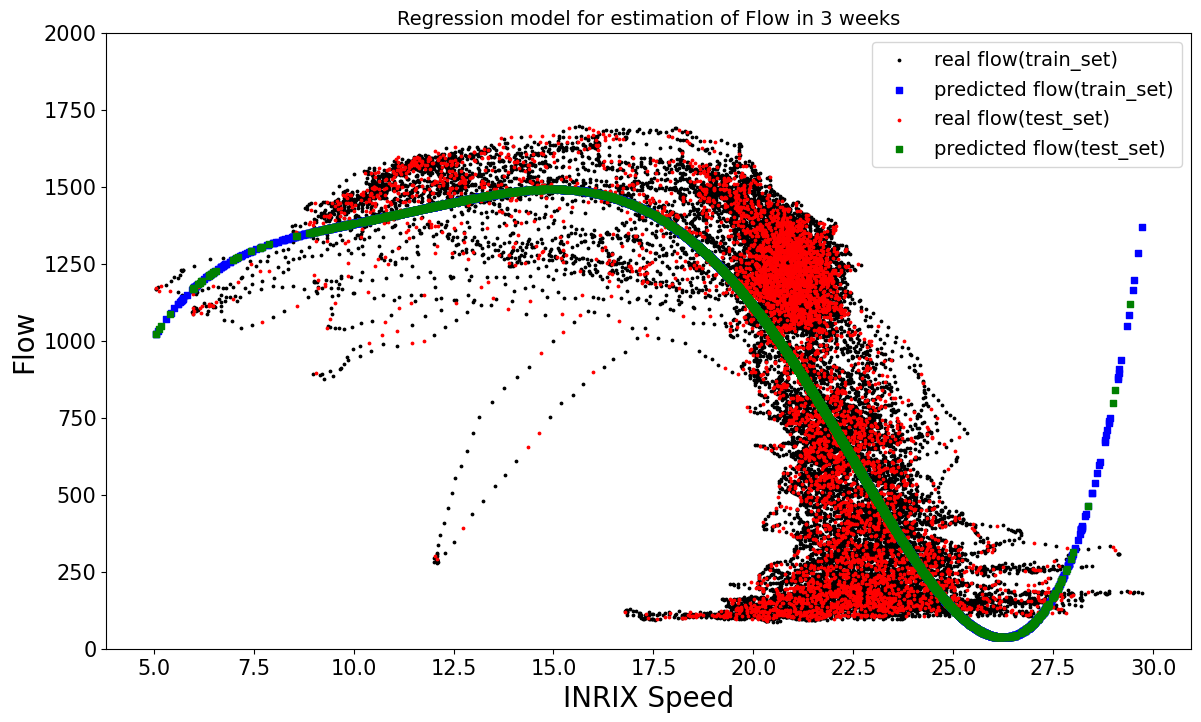

In [ ]:
# Plot real and predicted flow for X_train, X_test
X_train_denormalized = scaler_inrix_speed.inverse_transform(X_train[:,1:])
X_test_denormalized = scaler_inrix_speed.inverse_transform(X_test[:, 1:])
plt.figure(figsize=(14, 8))
plt.ylim(top = 2000)
#plt.xlim(left=-7, right = 2)
plt.xticks(np.arange(5, 40, step=2.5))
plotResult(X_train_denormalized[:, 0], Y_train, Y_predict_train, 
           X_test_denormalized[:, 0], Y_test, Y_predict_test, '3 weeks', 'INRIX Speed', 'Flow')

In [ ]:
# Use all dataset to train and predict the flow
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  351.7712016019422
R2 Score:  0.4901829366003152


In [ ]:
combinedSouth_2w.describe()

fk_id         speed  ...  travel_time_secs   Epoch_inrix
count  28576.0  28576.000000  ...      28576.000000  2.857600e+04
mean    1162.0     20.362330  ...         58.121714  9.133070e+05
std        0.0      2.940671  ...         16.429098  5.212836e+05
min     1162.0      2.350398  ...         39.654000  7.739000e+03
25%     1162.0     20.262472  ...         51.460000  4.622235e+05
50%     1162.0     20.919707  ...         54.078000  9.139460e+05
75%     1162.0     22.036207  ...         56.450000  1.364831e+06
max     1162.0     23.523643  ...        243.594000  1.813677e+06

[8 rows x 14 columns]

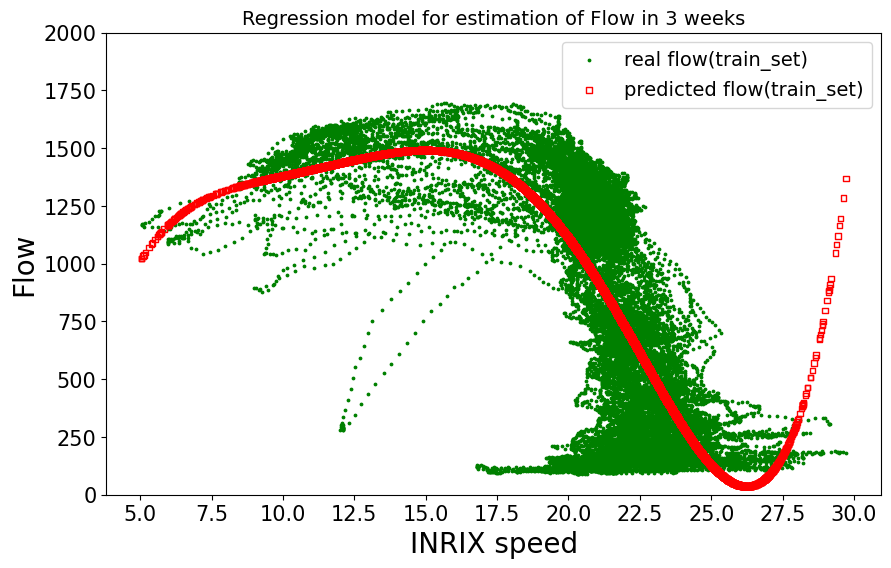

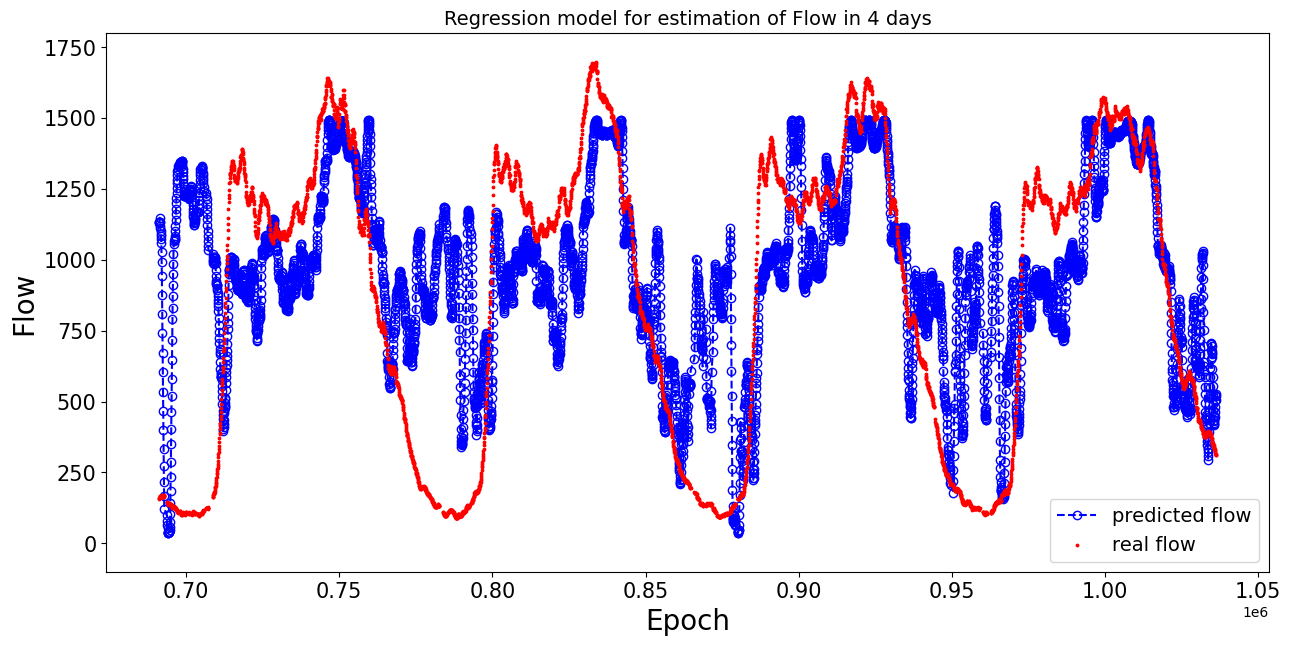

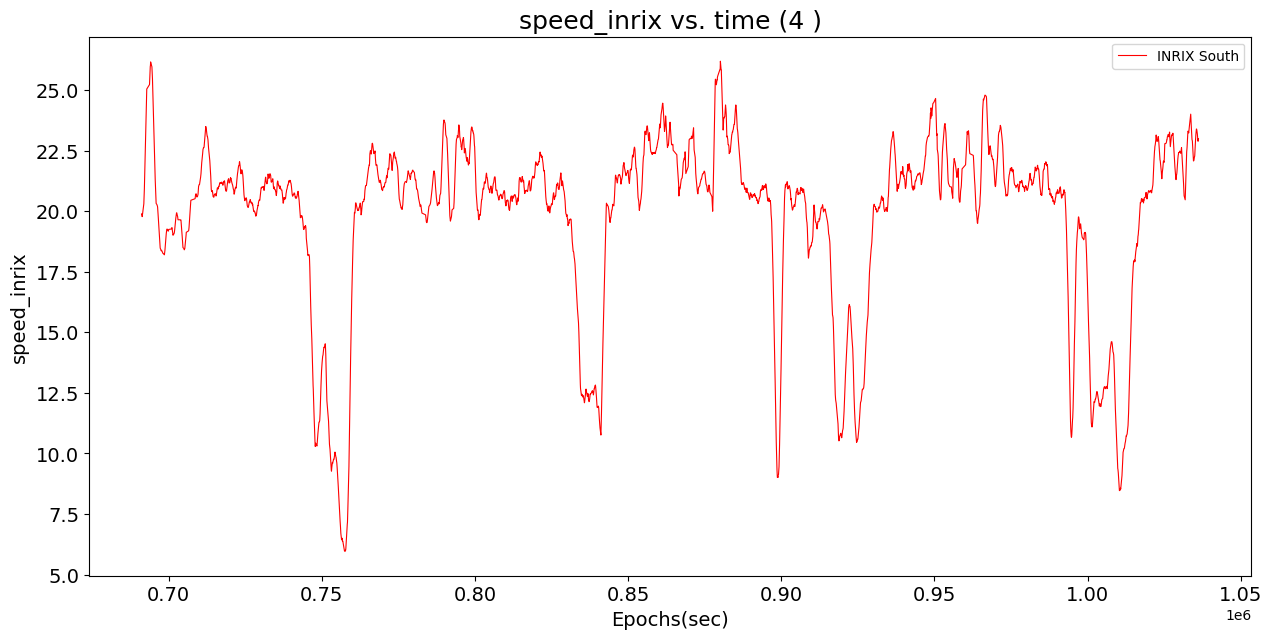

In [ ]:
# Plot real and predicted flow vs. X_features (speed_mcs)
X_features_inrix_denormalized = scaler_inrix_speed.inverse_transform(X_features[:,1:])
plt.figure(figsize=(10, 6))
plt.ylim(bottom = 0, top=2000)
plt.xticks(np.arange(5, 35, step=2.5))
plotResult(X_features_inrix_denormalized[:, 0], Y_label, Y_predict, 
           None,  None, None, '3 weeks', 'INRIX speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(15, 7))
plt.ylim(bottom = -100, top = 1800)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding inrix speed 
plt.figure(figsize=(15, 7))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed_inrix', 'INRIX South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

# 6. Dicision Tree


*   Use decision tree to extract dependency between MCS speed and (MCS) flow
*   Use decision tree to extract dependency between INRIX speed, INRIX travel time and (MCS) flow



## 6.1 Decision tree model: MCS speed -> MCS flow



In [ ]:
# function for quickly tuning the depth of the decision tree 
# (should use cross validation for hyper-parameter tuning)
# Input: decision tree model, train and test datasets, and a list that specifies the 
# depth splits, eg: split = [2, 3, 4, 5, 6] tests depth from 2 to 6
# Output: return the experiment result in as dataframe with 3 columns:
# depth split, r2 for test dataset, r2 for train dataset.
def quickSplitTuning(model, x_train, y_train, x_test, y_test, split):
  trainR2Array = []
  testR2Array = []
  for i in split:
    estimator = model(max_depth = i, random_state = 0)
    estimator.fit(x_train, y_train)
    trainR2Array.append(estimator.score(x_train, y_train))
    testR2Array.append(estimator.score(x_test, y_test))
  result = pd.DataFrame({'split': split, 'Train_R2': trainR2Array, 'Test_R2': testR2Array})
  
  return result


In [ ]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_mcs_speed = combinedSouth_2w['speed'].values.reshape(-1, 1)

X_features = X_mcs_speed
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28576, 1)


In [ ]:
# quick eperiment the max_depth splits(hyperparameters) 
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.767836  0.766777
1       2  0.834853  0.834146
2       3  0.859049  0.858180
3       4  0.870361  0.870180
4       5  0.873062  0.872361
5       6  0.874730  0.871455
6       7  0.876289  0.869697
7       8  0.879415  0.867221
8       9  0.882771  0.864087
9      10  0.887419  0.860746
10     11  0.892661  0.858535
11     12  0.898169  0.852531
12     13  0.904237  0.847051
13     14  0.910972  0.841292


    Split Experiment Result:
    depth = 5 or 6 has largest accuracy while not over-fitting

In [ ]:
# Hyperparameter tuning: depth of tree
# by using training set
DTRegressor = DecisionTreeRegressor()
print(DTRegressor.get_params)

# param_grid = {'max_depth': [3, 4, 5, 6, 7, 8], 
#               'min_samples_leaf': [1, 10, 100, 1000]}

param_grid = {'max_depth': [5], 
              'min_samples_leaf': [int(x) for x in np.arange(1, 20, step=1)]}
              
grid_search = GridSearchCV(DTRegressor, param_grid, cv=7, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>


{'max_depth': 5, 'min_samples_leaf': 10}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.8701113538634837 {'max_depth': 5, 'min_samples_leaf': 1}
0.8701849233406386 {'max_depth': 5, 'min_samples_leaf': 2}
0.8702536015716362 {'max_depth': 5, 'min_samples_leaf': 3}
0.870272955397235 {'max_depth': 5, 'min_samples_leaf': 4}
0.8702336413191277 {'max_depth': 5, 'min_samples_leaf': 5}
0.8702477609283029 {'max_depth': 5, 'min_samples_leaf': 6}
0.8702435808235656 {'max_depth': 5, 'min_samples_leaf': 7}
0.8702495767961091 {'max_depth': 5, 'min_samples_leaf': 8}
0.8703042992429569 {'max_depth': 5, 'min_samples_leaf': 9}
0.8703128035608717 {'max_depth': 5, 'min_samples_leaf': 10}
0.8702980617234759 {'max_depth': 5, 'min_samples_leaf': 11}
0.8702723655730474 {'max_depth': 5, 'min_samples_leaf': 12}
0.8702700961599396 {'max_depth': 5, 'min_samples_leaf': 13}
0.8702635104502167 {'max_depth': 5, 'min_samples_leaf': 14}
0.8702694902283029 {'max_depth': 5, 'min_samples_leaf': 15}
0.8702629607949115 {'max_depth': 5, 'min_samples_leaf': 16}
0.870261647189131 {'max_depth': 5, 'min_samples_le

In [ ]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 5
DT_MSL = 10 # minimum sample leaf
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, min_samples_leaf=10, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))


Root Mean Square Error:  175.67396231784076
R2 Score:  0.8729958188117694
Root Mean Square Error:  175.35665924807452
R2 Score:  0.8727350506608789


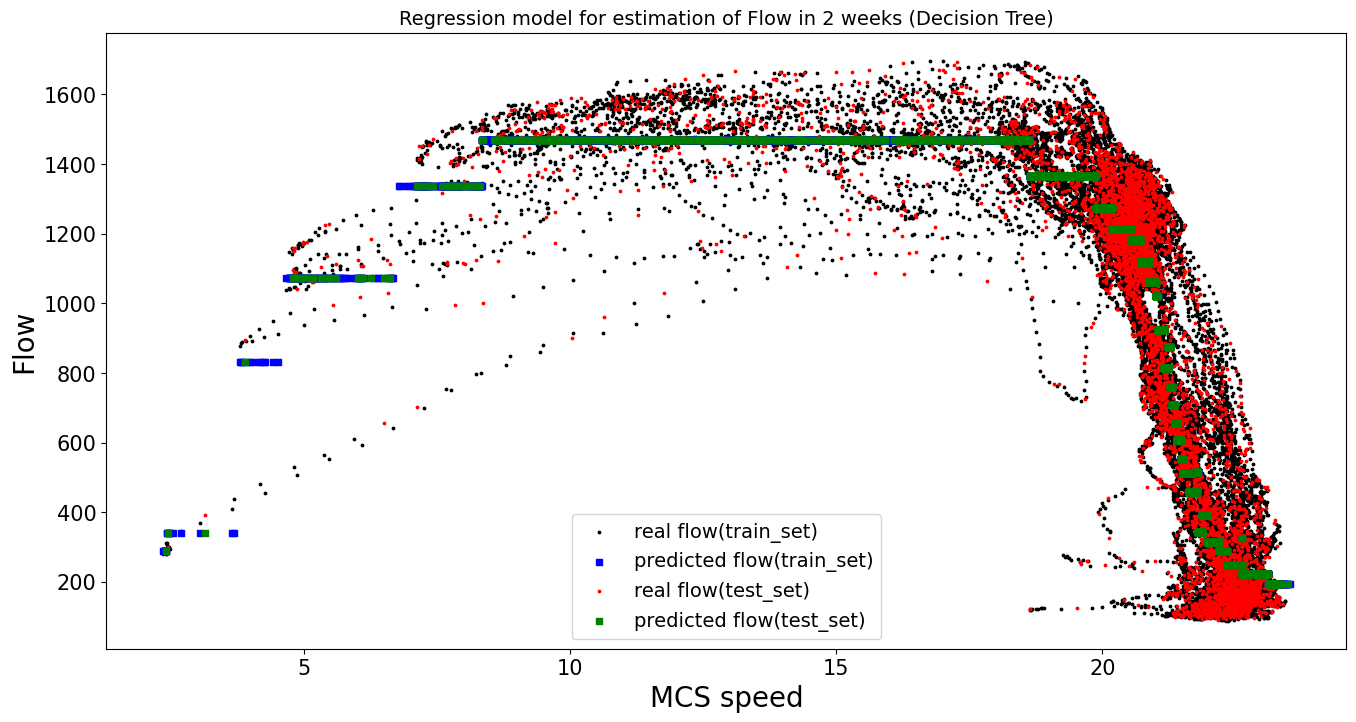

In [ ]:
# Plot real and predicted 'flow' vs 'mcs speed' 
plt.figure(figsize=(16, 8))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'MCS speed', 'Flow')


In [ ]:
# Use all data to predict the flow
# DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  175.6105386913367
R2 Score:  0.872944066090226


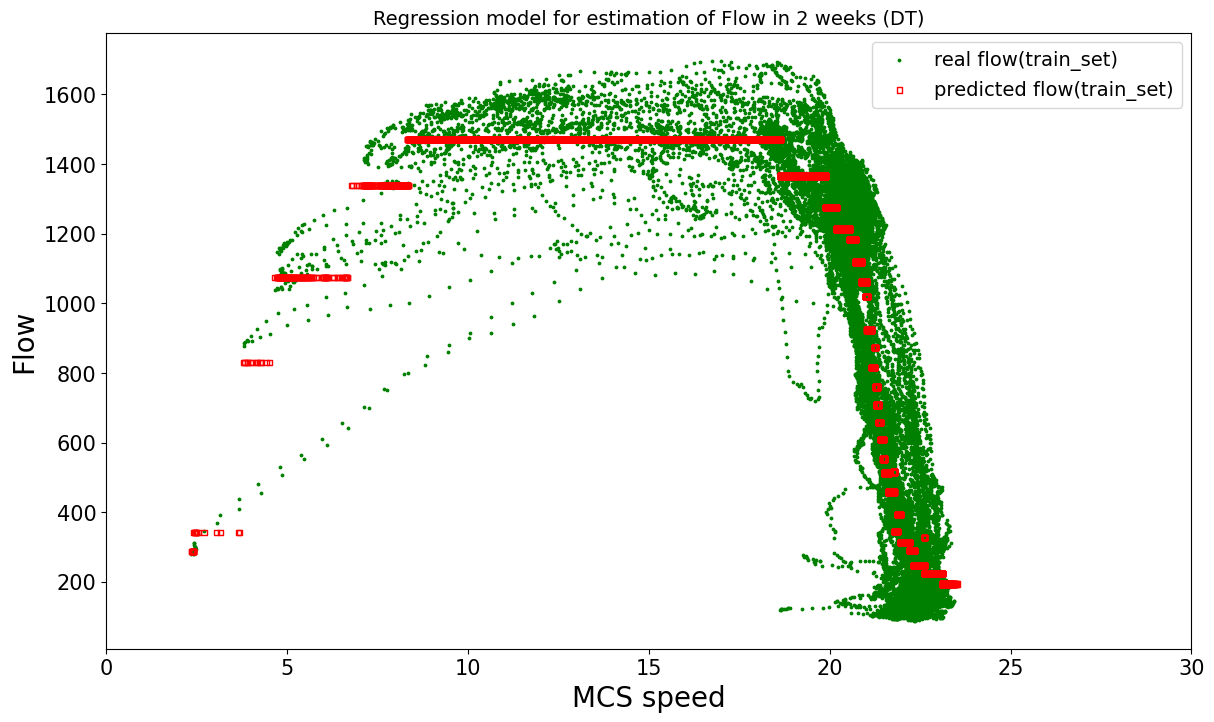

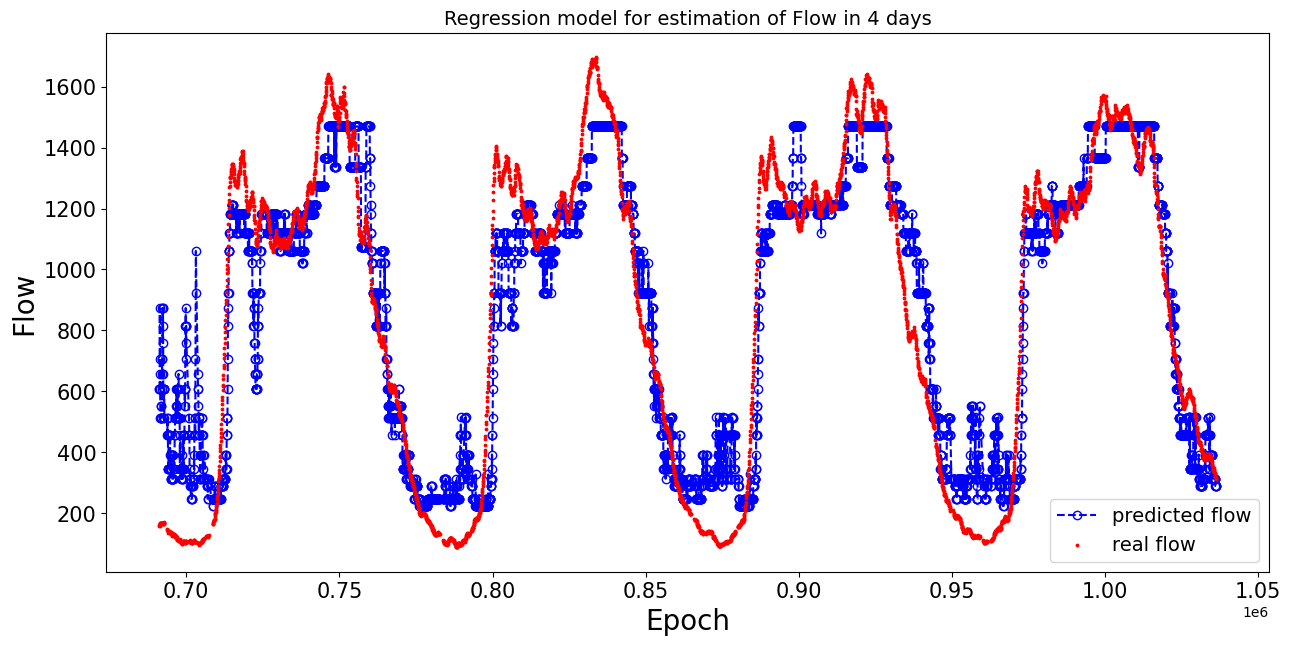

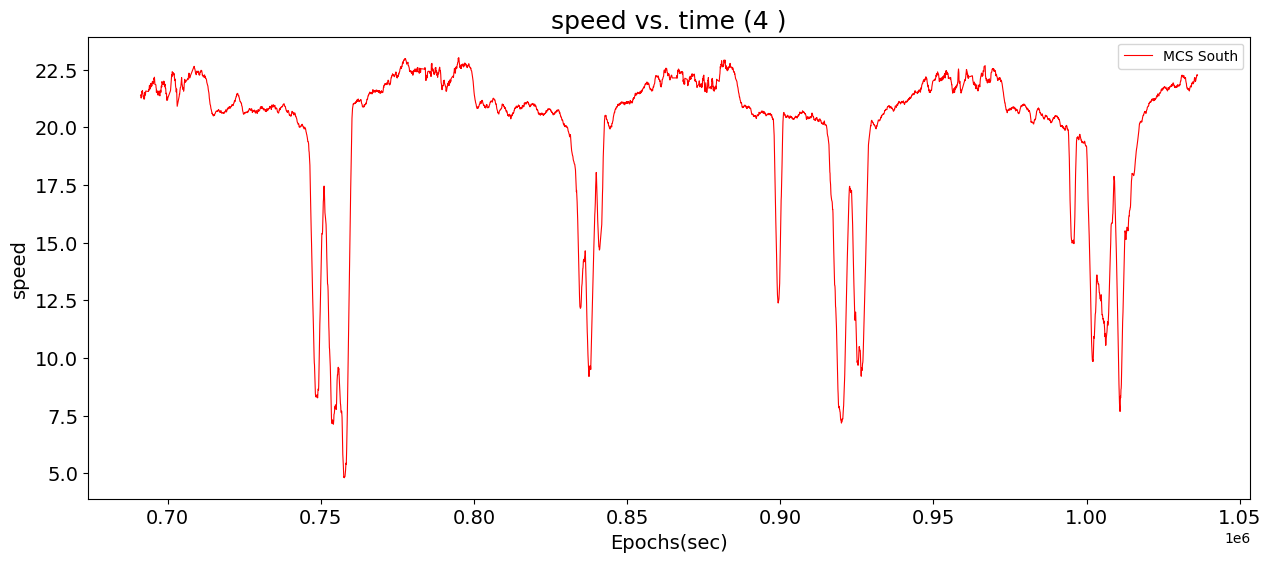

In [ ]:
# Plot real and predicted flow vs. X_features (speed_mcs)
plt.figure(figsize=(14, 8))
plt.xlim(right = 30)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'MCS speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(15, 7))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(15, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed', 'MCS South')



# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

## 4.2 Decision tree model: INRIX speed & Travel Time -> MCS flow



In [125]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_inrix_speed_travelTime = combinedSouth_2w[['speed_inrix', 'travel_time_secs']].values

X_features = X_inrix_speed_travelTime
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

(28576, 2)


In [126]:
# temporarily tune the max_depth (hyperparameters) 
# Notice: should use cross-validation instead, here only for quick result
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.391019  0.389714
1       2  0.479867  0.482122
2       3  0.511557  0.508157
3       4  0.523350  0.518705
4       5  0.534513  0.524210
5       6  0.545473  0.529690
6       7  0.554809  0.534568
7       8  0.565985  0.537484
8       9  0.580354  0.536915
9      10  0.594048  0.535774
10     11  0.610313  0.527163
11     12  0.629230  0.513179
12     13  0.655380  0.498414
13     14  0.677897  0.488035


In [99]:
# Hyperparameter tuning: depth of tree
# by using training set
DTRegressor = DecisionTreeRegressor()
print(DTRegressor.get_params)

# param_grid = {'max_depth': [int(x) for x in np.arange(1, 20, step=2)], 
#               'min_samples_leaf': [1, 10, 100, 1000]}

param_grid = {'max_depth': [9], 
              'min_samples_leaf': [int(x) for x in np.arange(30, 50, step=1)]}

              
grid_search = GridSearchCV(DTRegressor, param_grid, cv=7, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>


{'max_depth': 9, 'min_samples_leaf': 42}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.5364716522154185 {'max_depth': 9, 'min_samples_leaf': 30}
0.5365122658764029 {'max_depth': 9, 'min_samples_leaf': 31}
0.5367709408918645 {'max_depth': 9, 'min_samples_leaf': 32}
0.5369793693543637 {'max_depth': 9, 'min_samples_leaf': 33}
0.5368739572220982 {'max_depth': 9, 'min_samples_leaf': 34}
0.5373254767990941 {'max_depth': 9, 'min_samples_leaf': 35}
0.5372225861919633 {'max_depth': 9, 'min_samples_leaf': 36}
0.5374353300184073 {'max_depth': 9, 'min_samples_leaf': 37}
0.5374750848575497 {'max_depth': 9, 'min_samples_leaf': 38}
0.5368382238147259 {'max_depth': 9, 'min_samples_leaf': 39}
0.5369073054945972 {'max_depth': 9, 'min_samples_leaf': 40}
0.5375318009870041 {'max_depth': 9, 'min_samples_leaf': 41}
0.5376529964860509 {'max_depth': 9, 'min_samples_leaf': 42}
0.537400224315849 {'max_depth': 9, 'min_samples_leaf': 43}
0.5375979262059937 {'max_depth': 9, 'min_samples_leaf': 44}
0.5374756077584343 {'max_depth': 9, 'min_samples_leaf': 45}
0.5375311972769953 {'max_depth': 9, 'min_

In [127]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 9
DT_MSL = 42
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, min_samples_leaf= DT_MSL, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
scores = cross_val_score(DTRegressor, X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)
print()
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score for testing set: ", r2_score(Y_test, Y_predict_test))


Scores: [0.53822529 0.53950055 0.54729432 0.51928523 0.53938049 0.54373646
 0.53344183 0.52293883 0.55424862 0.54906895]
Mean: 0.5387120566227038
Standard deviation: 0.010501555534165725

Root Mean Square Error:  326.33228749490115
R2 Score for training set:  0.5617485965130813
Root Mean Square Error:  333.56507637583275
R2 Score for testing set:  0.5395044561654478


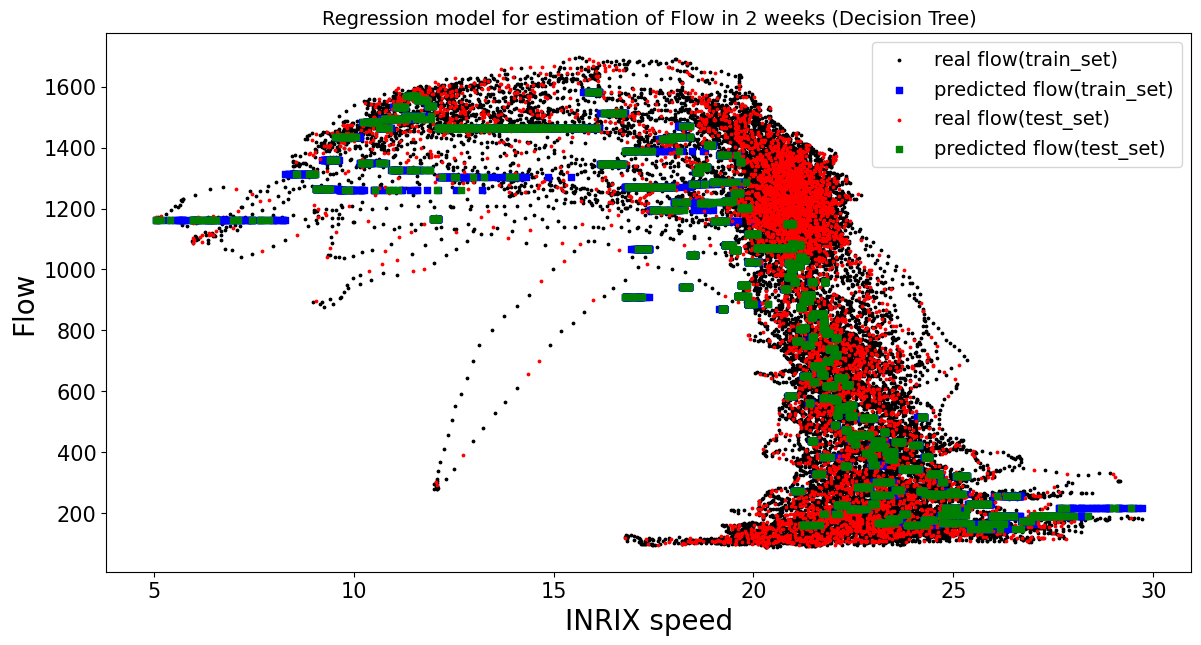

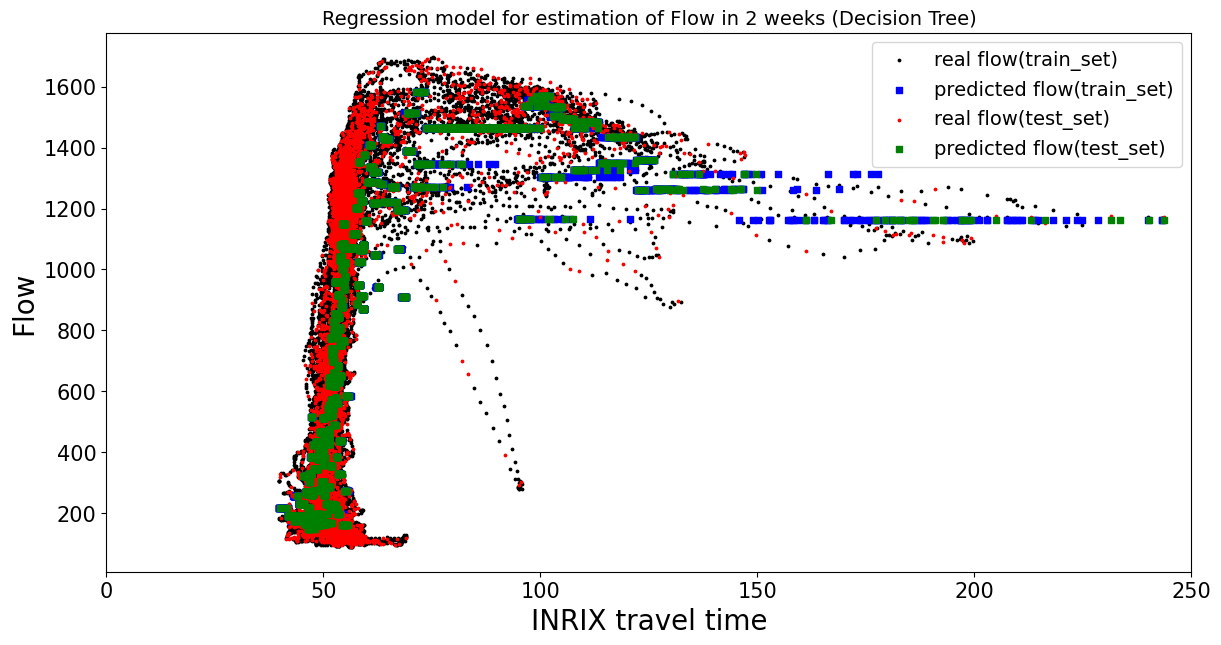

In [128]:
 # Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(14, 7))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed', 'Flow')

# Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(14, 7))
plt.xlim(right = 250)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time', 'Flow')

In [129]:
# Use all data to predict the flow
DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)

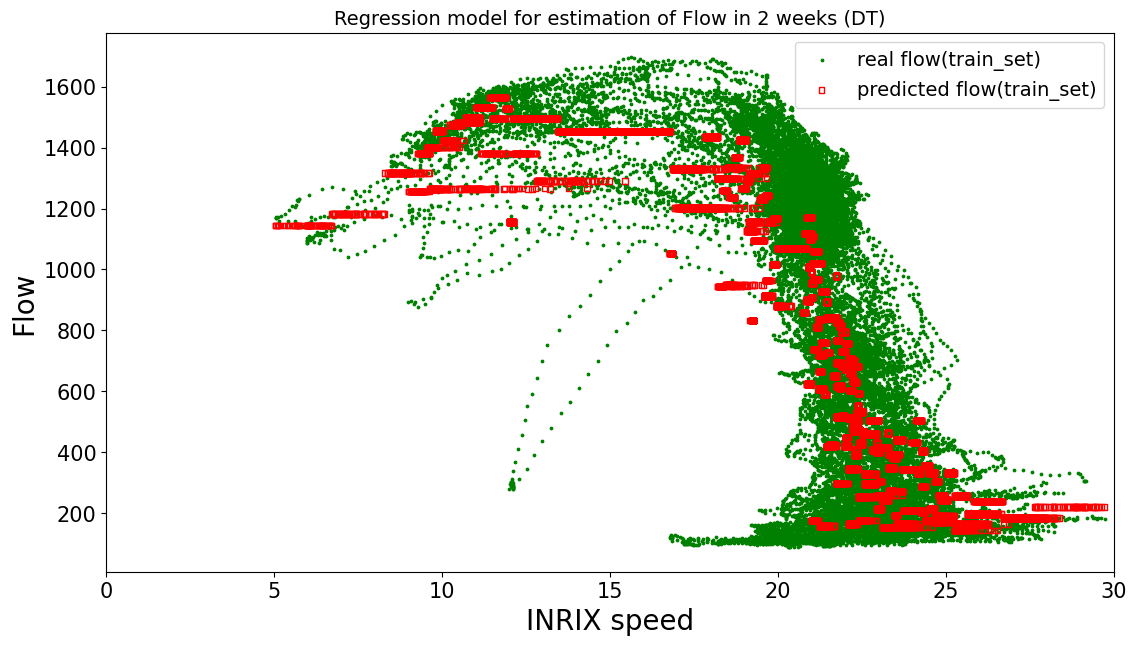

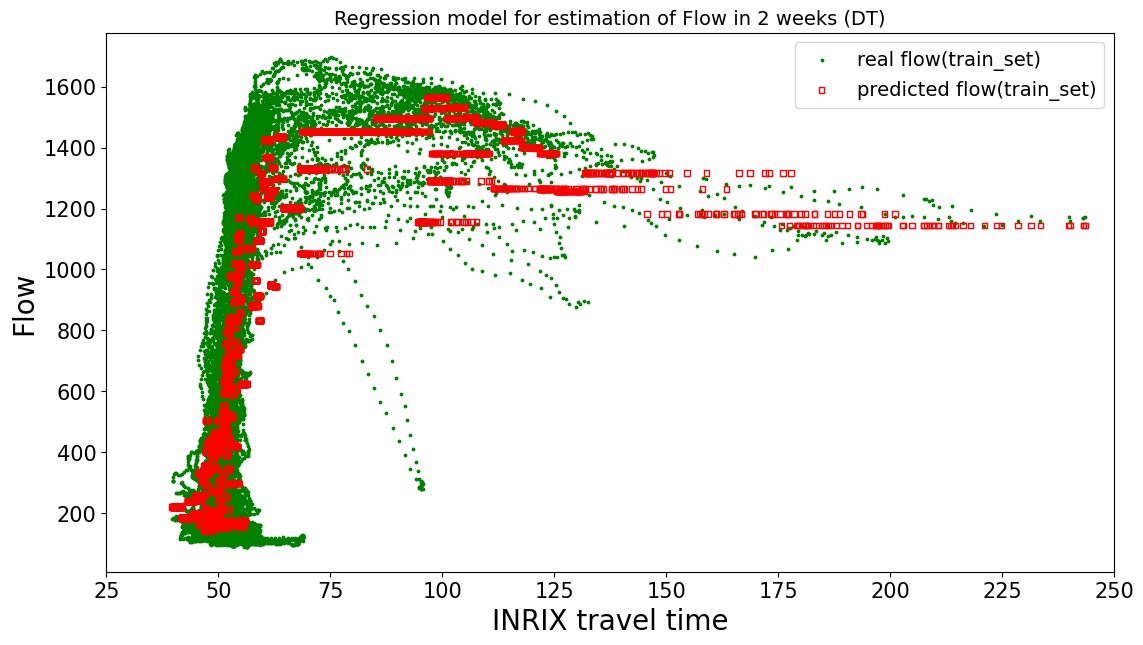

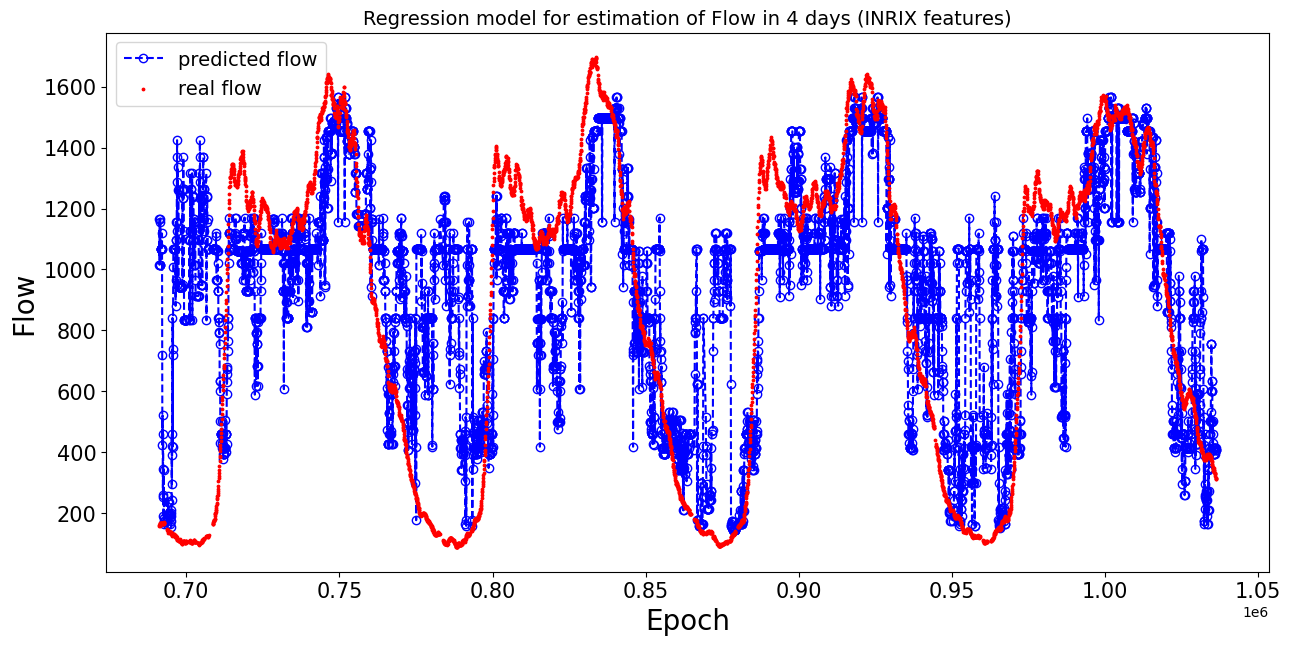

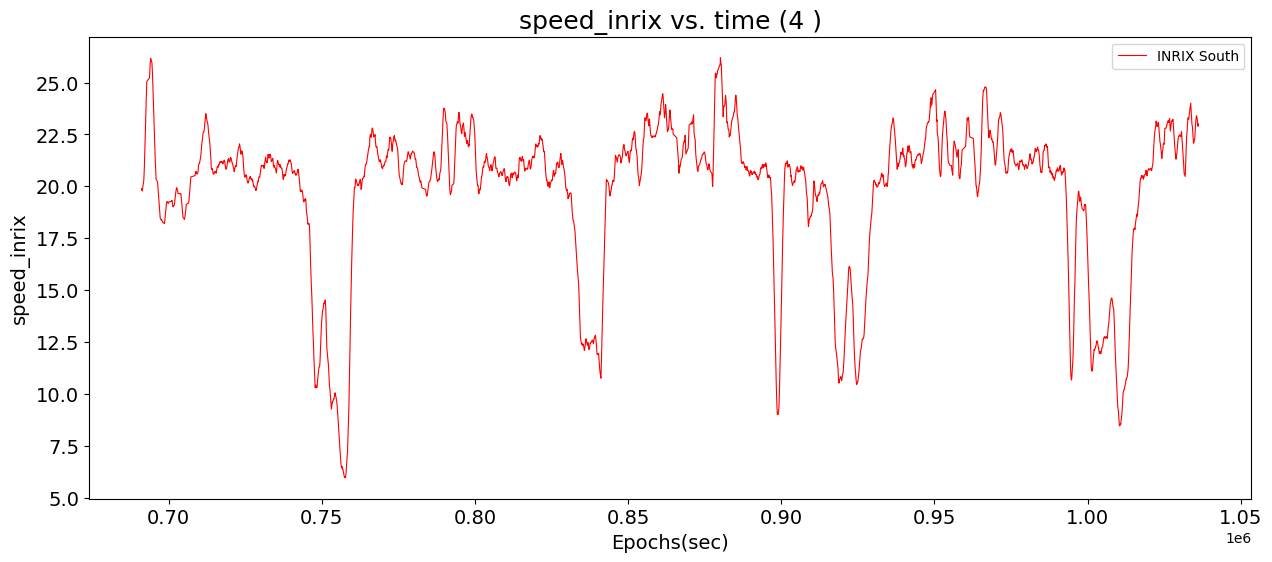

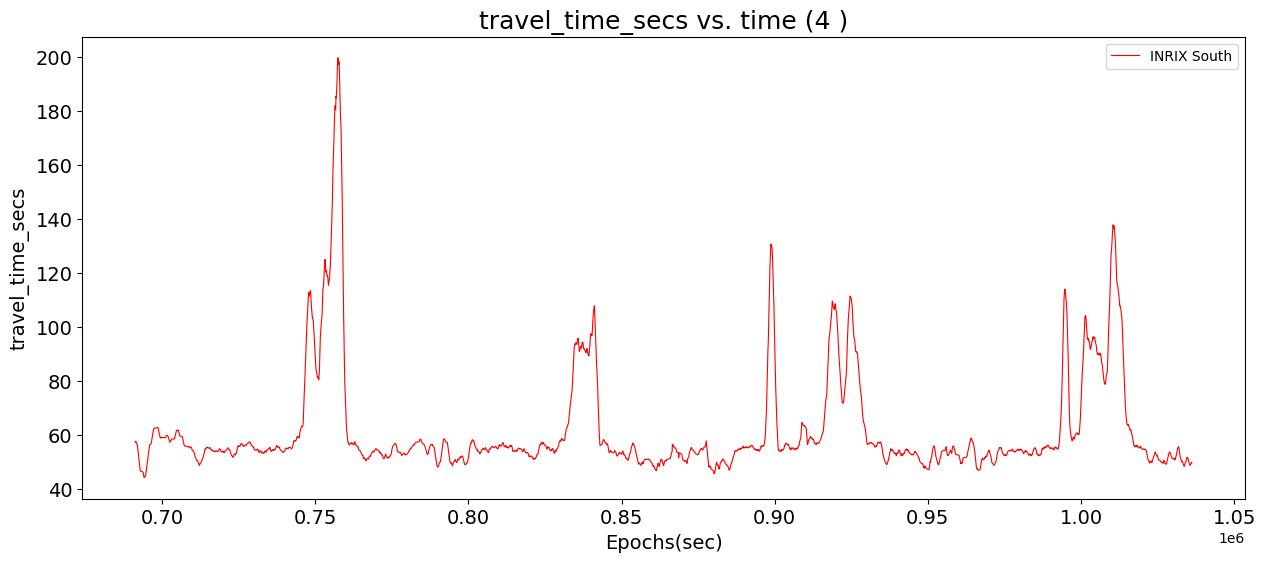

In [130]:
# Plot real and predicted flow vs. X_features (speed)
plt.figure(figsize=(13, 7))
plt.xlim(right = 30)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'INRIX speed', 'Flow')

# Plot real and predicted flow vs. X_features (travel time)
plt.figure(figsize=(13, 7))
plt.xlim(left= 25, right = 250)
plotResult(X_features[:, 1], Y_label, Y_predict, 
           None,  None, None, '2 weeks (DT)', 'INRIX travel time', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(15, 7))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days (INRIX features)', 'Epoch', 'Flow', 'p')

# Plot corresponding inrix speed 
plt.figure(figsize=(15, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed_inrix', 'INRIX South')

# Plot corresponding mcs & inrix travel time
plt.figure(figsize=(15, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'travel_time_secs', 'INRIX South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

In [131]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed_inrix', 'travel_time_secs']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = DTRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6687, 2)
Root Mean Square Error:  340.00358230718604
R2 Score:  0.5267283099969331


# 5. Random Forest


*   Random Forest for mapping MCS speed -> MCS flow
*   Random Forest for mapping INRIX speed -> MCS flow
*   Cross Validation for tunig hyperparameters( depth & tree number) in random forest tree




## 5.1 Random Forest tree for mapping MCS speed to MCS flow

In [ ]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
# X_mcs_speed was already assigned at 4.1 
X_features = X_mcs_speed
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28576, 1)


In [ ]:
## Hyperparameter tuning: random search
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)

# Number of trees in random forest
n_estimators = [10, 100, 200]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 3)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)


# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = RFRegressor, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='r2')
# rf_random.fit(X_train, Y_train)

# rf_random.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>
{'n_estimators': [10, 100, 200], 'max_depth': [2, 11, 20, None], 'min_samples_leaf': [1, 10, 50, 100]}


In [ ]:
# Hyperparameter tuning: grid search
param_grid = {'n_estimators': [100],
              'max_depth': [6],
              'min_samples_leaf': [int(x) for x in np.arange(5, 12, step=1)]}
              
grid_search = GridSearchCV(estimator = RFRegressor, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   13.6s finished


{'max_depth': 6, 'min_samples_leaf': 8, 'n_estimators': 100}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.8712588703354852 {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 100}
0.8713309455187995 {'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 100}
0.8713009933450552 {'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 100}
0.871341223775775 {'max_depth': 6, 'min_samples_leaf': 8, 'n_estimators': 100}
0.8711742942895903 {'max_depth': 6, 'min_samples_leaf': 9, 'n_estimators': 100}
0.8711826870270452 {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 100}
0.8711009806339965 {'max_depth': 6, 'min_samples_leaf': 11, 'n_estimators': 100}


In [ ]:
# fit the random forest model with tuned hyperparameters
RF_MAXDEPTH = 6
RF_NTREE = 100
RF_MSL = 8

RFRegressor = RandomForestRegressor(n_estimators= RF_NTREE, max_depth= RF_MAXDEPTH, min_samples_leaf=RF_MSL, n_jobs=-1)

# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(RFRegressor, X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

# fit the model on whole training set
# evaluate Performance of model (fitting result) on training set
RFRegressor.fit(X_train, Y_train)
Y_predict_train = RFRegressor.predict(X_train)
print('\nfitting result on whole training set:')
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for fitting result on training set: ", RFRegressor.score(X_train, Y_train))

# Evaluate Performance of the fitted model on testing set
Y_predict_test = RFRegressor.predict(X_test)
print('\nprediction result on testing set:')
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score on testing set: ", r2_score(Y_test, Y_predict_test))

Scores: [0.8728674  0.85905488 0.87334114 0.86738046 0.85921284 0.87821257
 0.88667059 0.86934769 0.87541587 0.87211475]
Mean: 0.8713618188778673
Standard deviation: 0.00789584837193309

fitting result on whole training set:
Root Mean Square Error:  174.15155849672712
R2 Score for fitting result on training set:  0.8751875363343493

prediction result on testing set:
Root Mean Square Error:  175.41166354575907
R2 Score on testing set:  0.8726551994929169


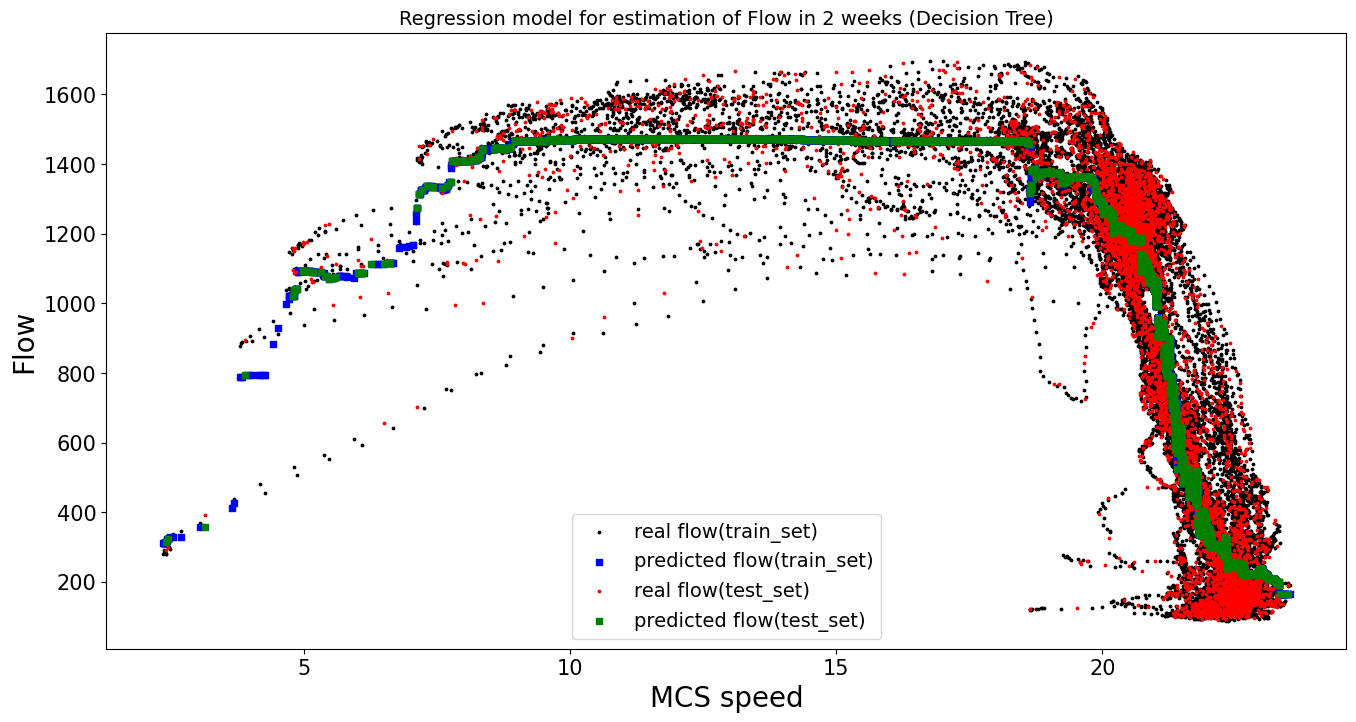

In [ ]:
# Plot real and predicted 'flow' vs 'mcs speed' 
plt.figure(figsize=(16, 8))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'MCS speed', 'Flow')

In [ ]:
# Use all data and the fitted model to predict the flow (used for drawing the plot)
Y_predict = RFRegressor.predict(X_features)

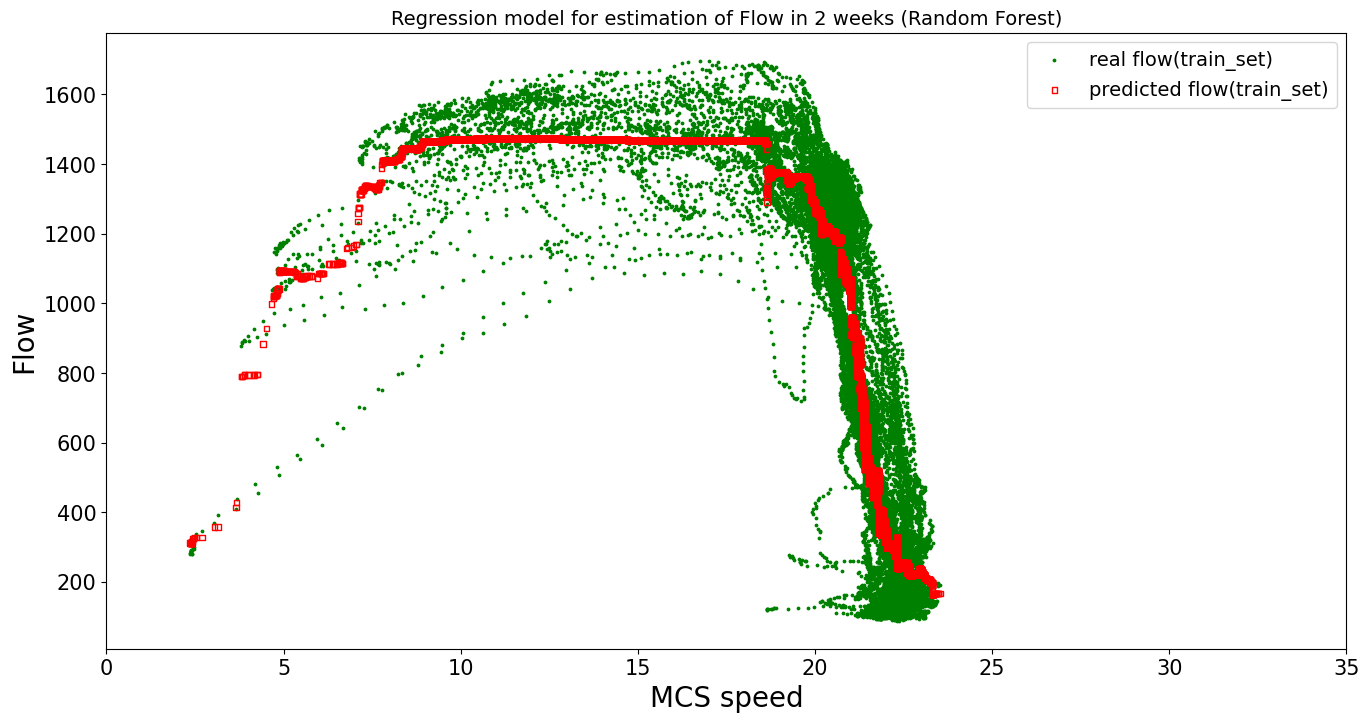

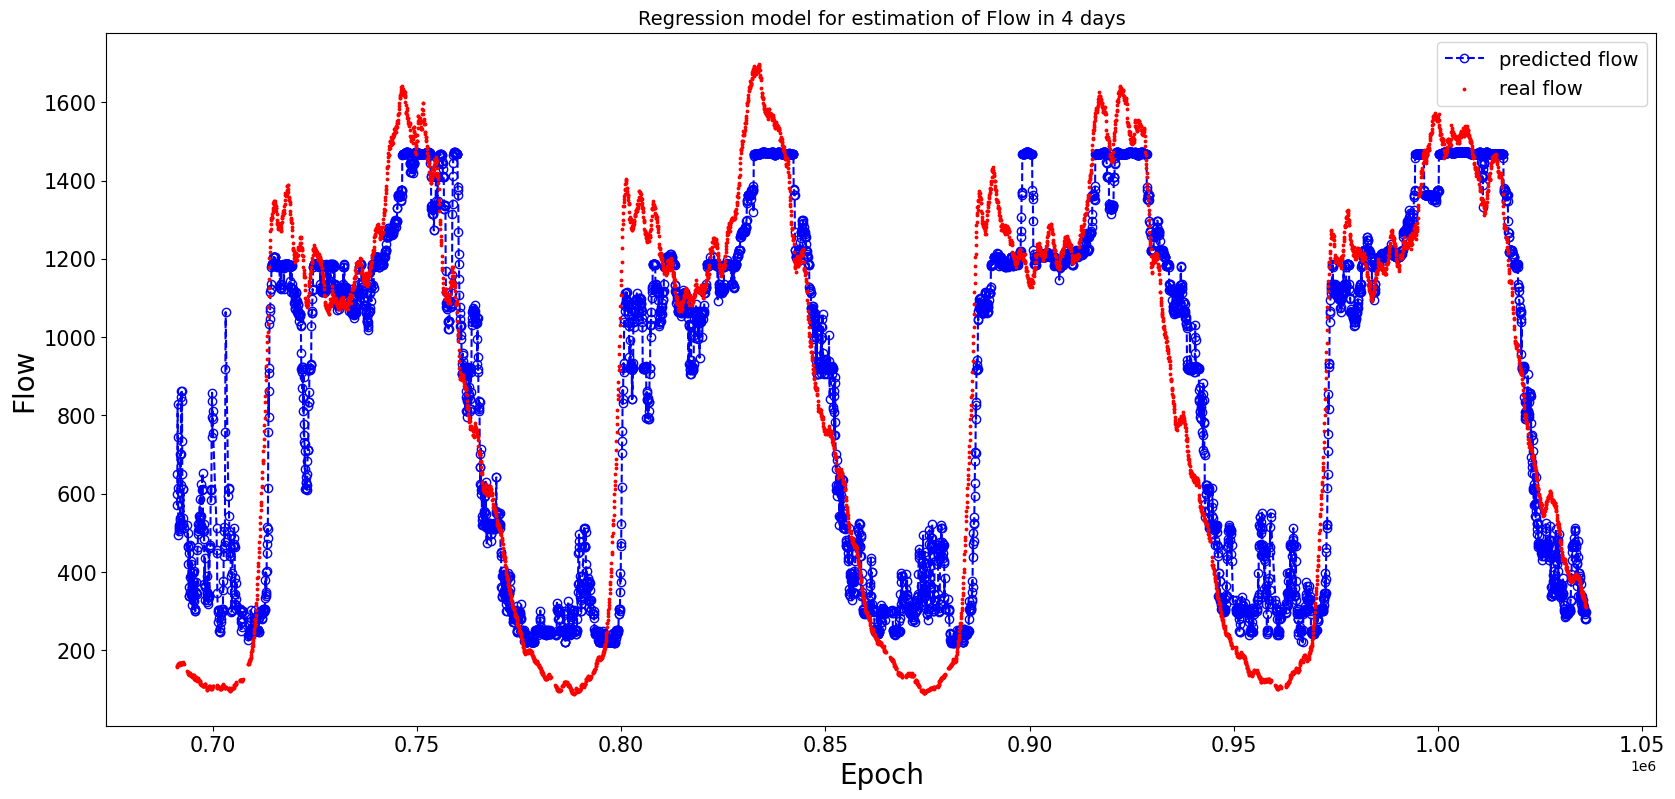

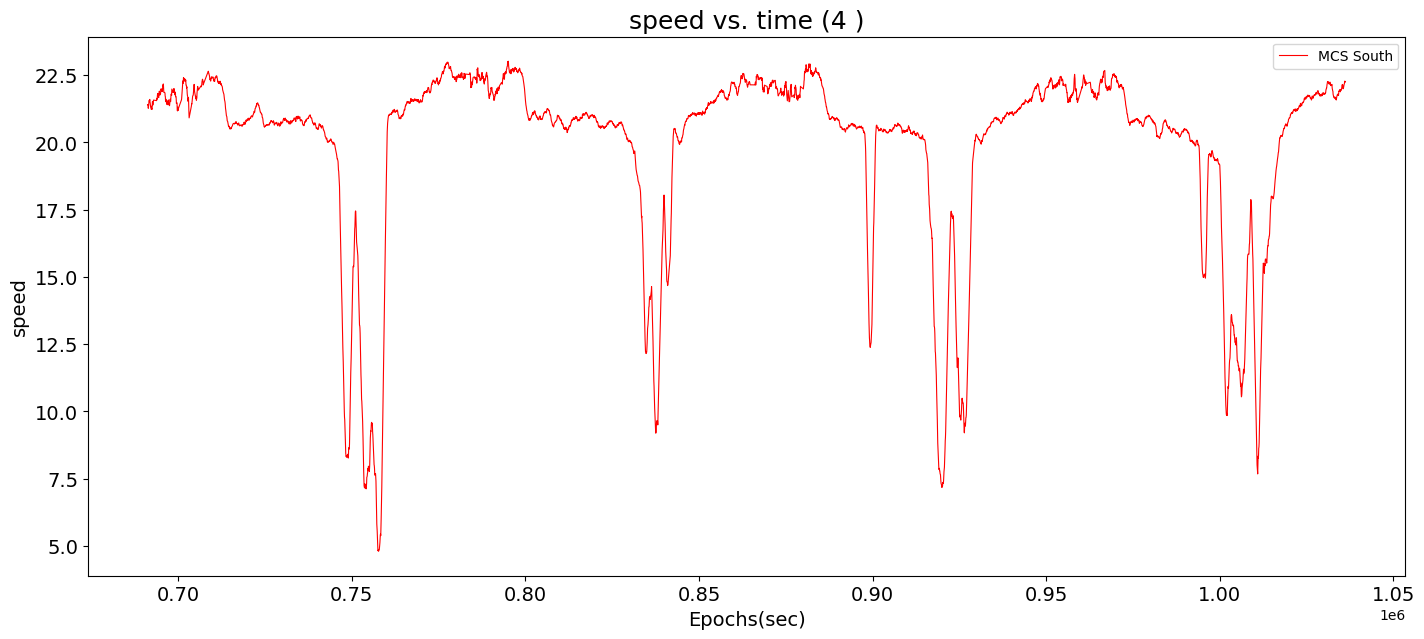

In [ ]:
# Plot real and predicted flow vs. X_features (speed_mcs)
plt.figure(figsize=(16, 8))
plt.xlim(right = 35)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (Random Forest)', 'MCS speed', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(17, 7))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed', 'MCS South')



## 5.2 Random Forest tree for mapping INRIX speed to MCS flow

In [111]:
# prepare the features [INRIX speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
# X_inrix_speed was already assigned at section 4
X_features = X_inrix_speed_travelTime
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28576, 2)


In [112]:
# Hyperparameter tuning: # and depth of tree
# by using training set
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)
param_grid = {'n_estimators': [int(x) for x in np.arange(100, 400, step=100)],
              'max_depth': [int(x) for x in np.arange(2, 12, step=2)],
              'min_samples_leaf': [1, 5, 25, 125]
              }
grid_search = GridSearchCV(estimator = RFRegressor, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [94]:
# Hyperparameter tuning: # and depth of tree
# by using training set
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)
param_grid = {'n_estimators': [200],
              'max_depth': [10],
              'min_samples_leaf': [int(x) for x in np.arange(1, 50, step=5)]
              }
grid_search = GridSearchCV(estimator = RFRegressor, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}

In [95]:
# print the results of cross-validation for hyper-parameters
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.5580569925700184 {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
0.5557323120363509 {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 200}
0.5533572815889495 {'max_depth': 10, 'min_samples_leaf': 11, 'n_estimators': 200}
0.5519959693967906 {'max_depth': 10, 'min_samples_leaf': 16, 'n_estimators': 200}
0.5509232307752482 {'max_depth': 10, 'min_samples_leaf': 21, 'n_estimators': 200}
0.5496984647660536 {'max_depth': 10, 'min_samples_leaf': 26, 'n_estimators': 200}
0.5480244804792254 {'max_depth': 10, 'min_samples_leaf': 31, 'n_estimators': 200}
0.5471236756183434 {'max_depth': 10, 'min_samples_leaf': 36, 'n_estimators': 200}
0.545795038570338 {'max_depth': 10, 'min_samples_leaf': 41, 'n_estimators': 200}
0.5448030386111626 {'max_depth': 10, 'min_samples_leaf': 46, 'n_estimators': 200}


min_sample_leaf= 50<br>
train: 0.568
test: 0.554
future: 0.541<br>
min_sample_leaf= 1<br>
train: 0.616
test: 0.563
future: 0.533<br>


In [120]:
# fit the random forest model on whole training set with the tuned hyperparameters
RF_NTREE = 200
RF_MAXDEPTH = 10
RF_MSL = 1

RFRegressor = RandomForestRegressor(n_estimators= RF_NTREE, max_depth=RF_MAXDEPTH, min_samples_leaf=RF_MSL, n_jobs=-1)

# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(RFRegressor, X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

# fit the model on whole training set
# evaluate Performance of model (fitting result) on training set
RFRegressor.fit(X_train, Y_train)
Y_predict_train = RFRegressor.predict(X_train)
print('\nfitting result on whole training set:')
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for fitting result on training set: ", RFRegressor.score(X_train, Y_train))

# Evaluate Performance of the fitted model on testing set
Y_predict_test = RFRegressor.predict(X_test)
print('\nprediction result on testing set:')
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score on testing set: ", r2_score(Y_test, Y_predict_test))

Scores: [0.563164   0.56402985 0.56528677 0.54179271 0.56221173 0.56063948
 0.55521304 0.54919175 0.57406962 0.57027491]
Mean: 0.5605873848801751
Standard deviation: 0.009114920820298423

fitting result on whole training set:
Root Mean Square Error:  305.3837127960432
R2 Score for fitting result on training set:  0.6162088403886996

prediction result on testing set:
Root Mean Square Error:  324.83894373403916
R2 Score on testing set:  0.563282633792866


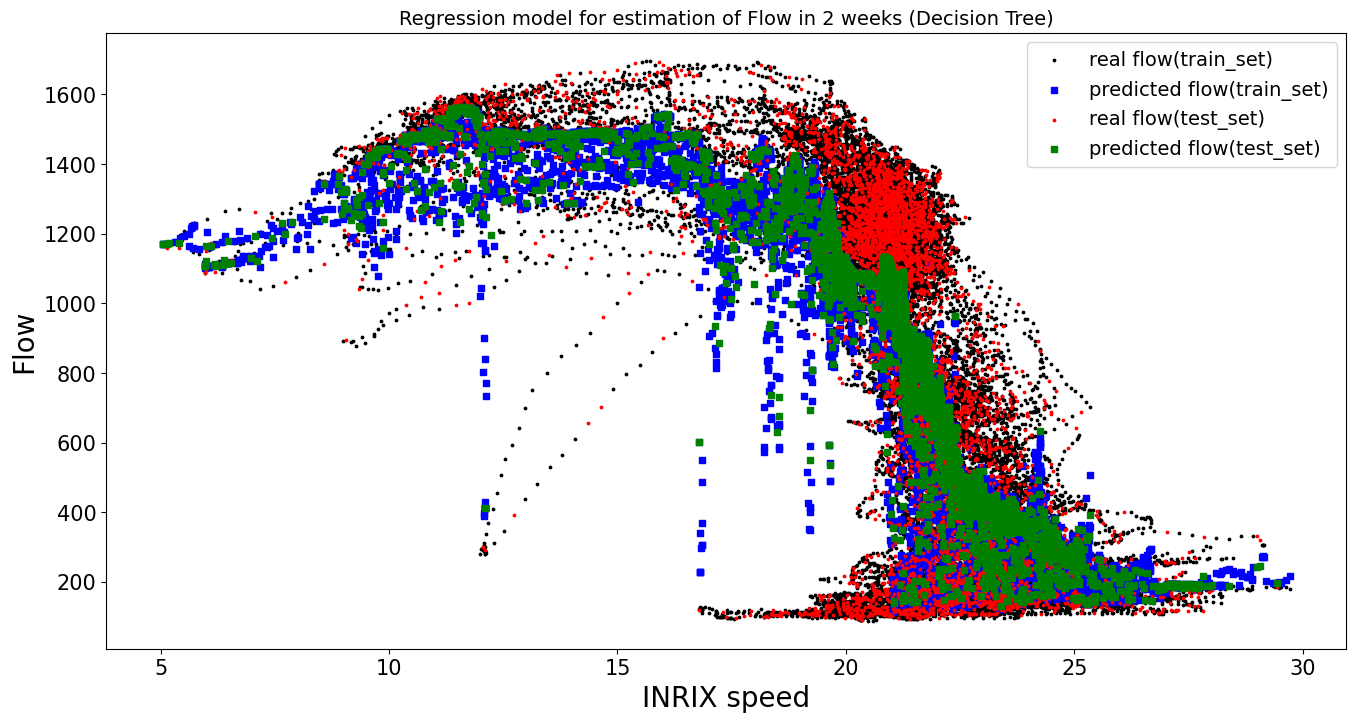

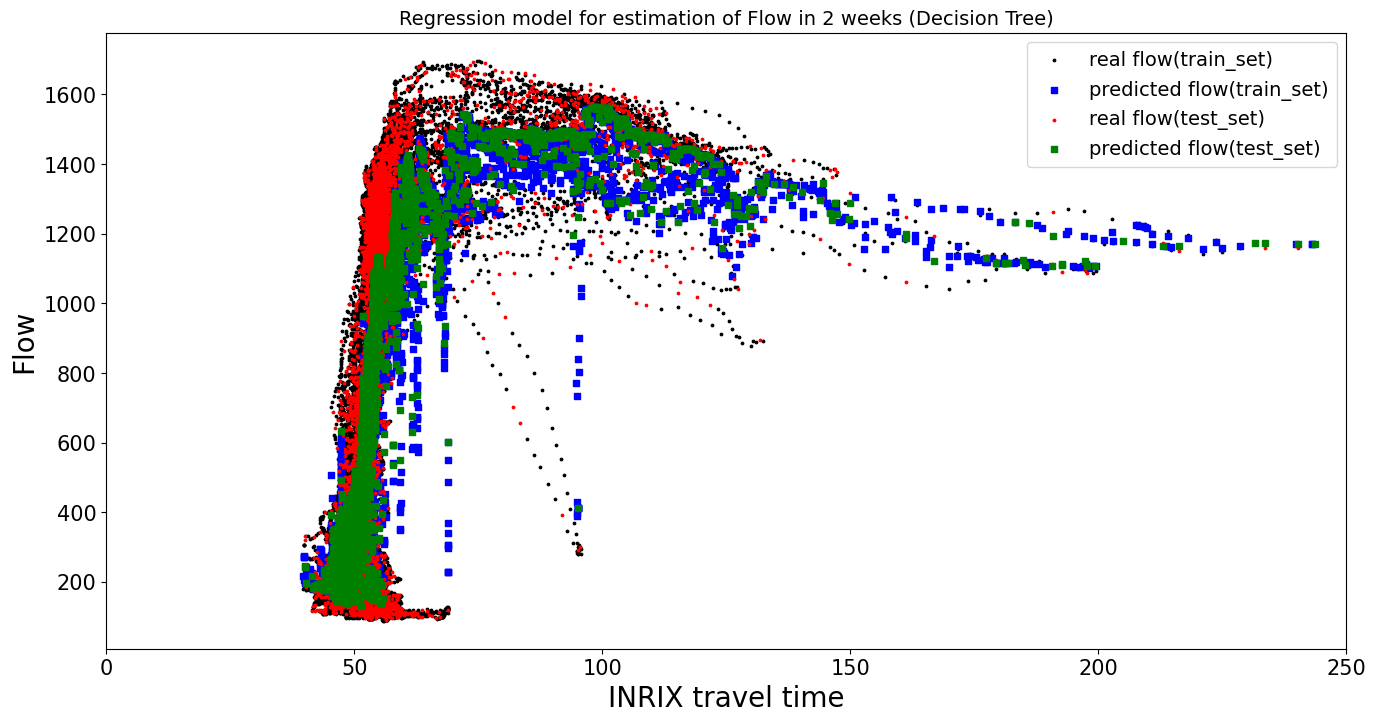

In [121]:
# Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(16, 8))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed', 'Flow')

# Plot real and predicted 'flow' vs 'speed' 
plt.figure(figsize=(16, 8))
plt.xlim(right = 250)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time', 'Flow')

In [122]:
# Use all data and the fitted model to predict the flow (used for drawing the plot)
Y_predict = RFRegressor.predict(X_features)

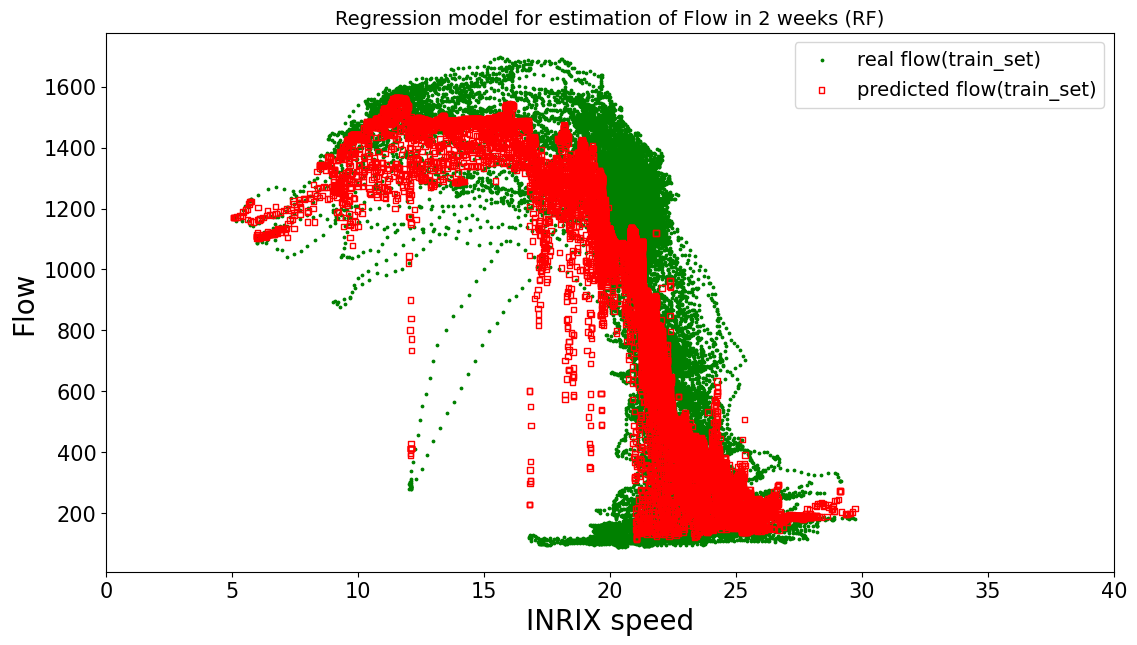

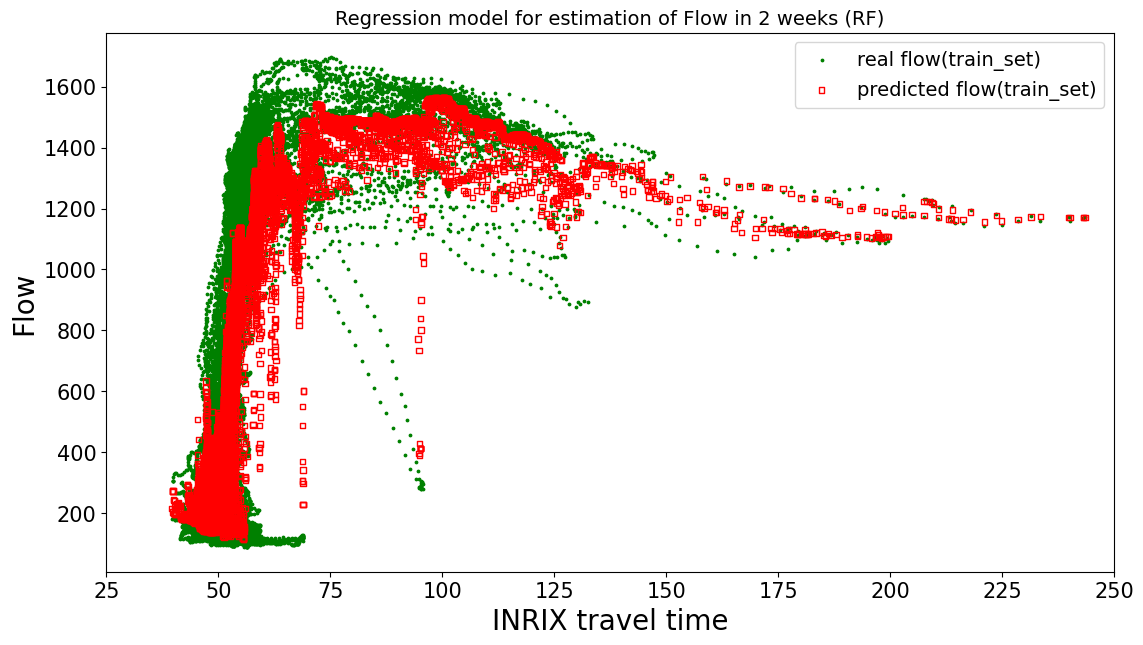

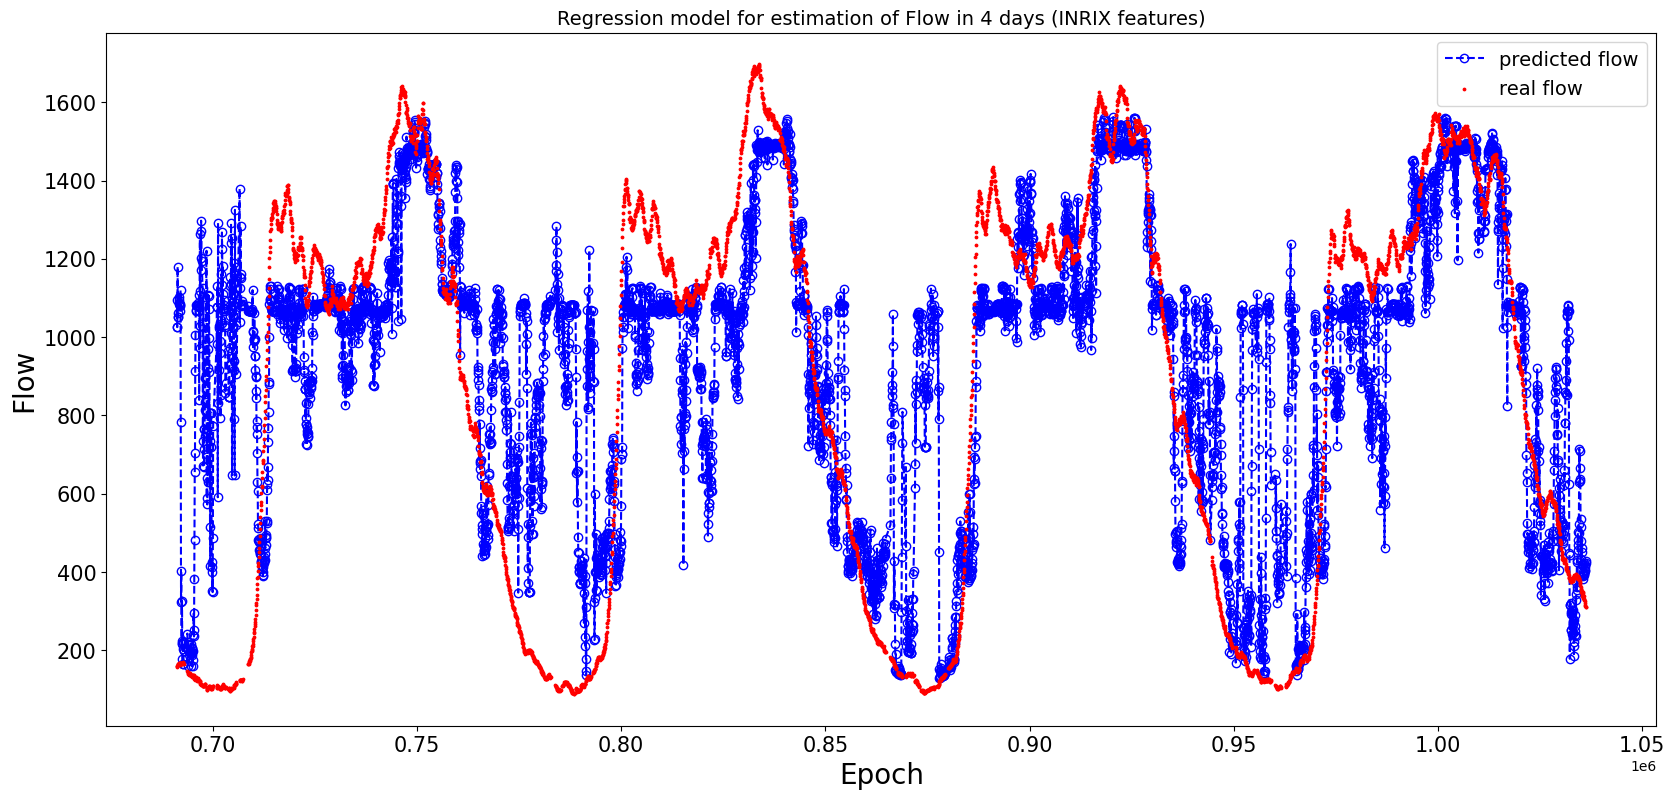

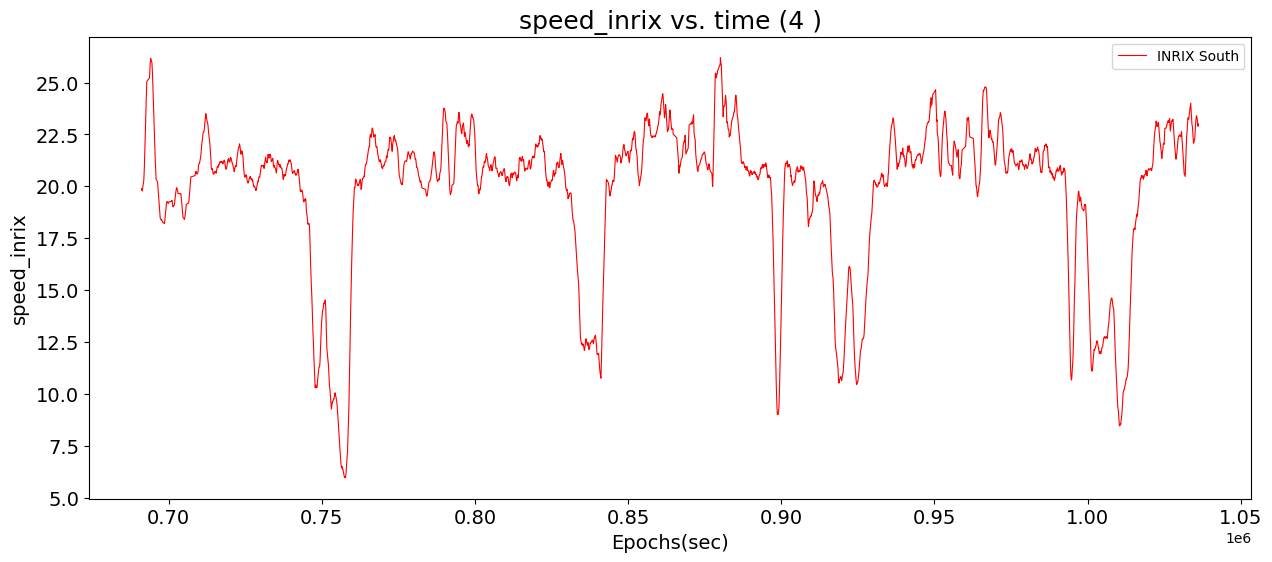

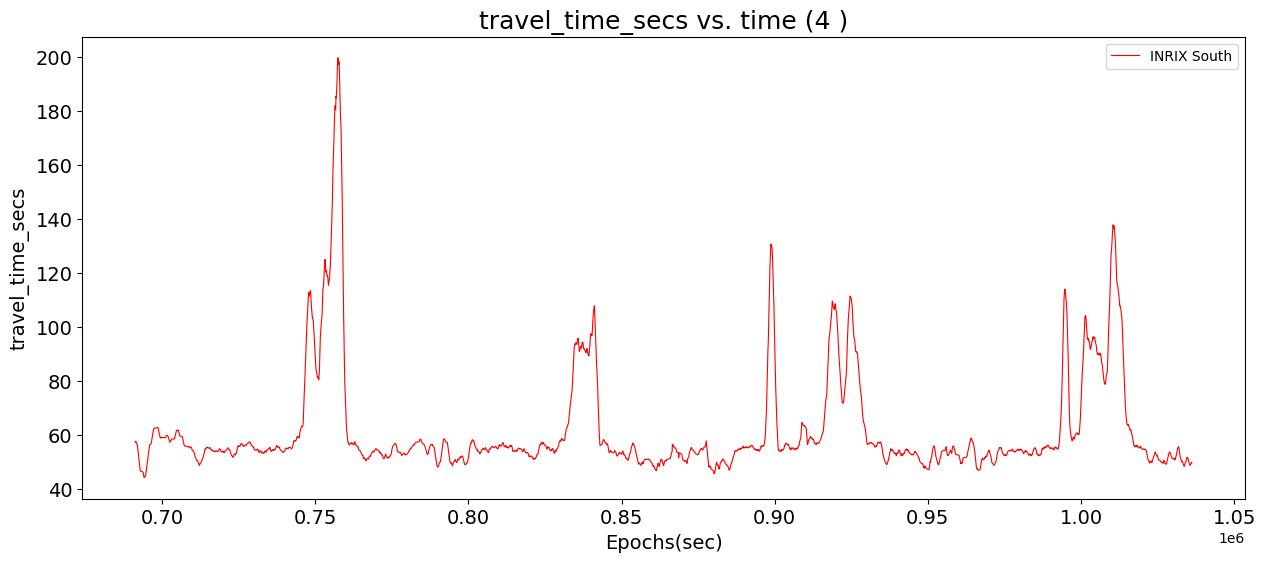

In [123]:
# Plot real and predicted flow vs. X_features (speed)
plt.figure(figsize=(13, 7))
plt.xlim(right = 40)
plotResult(X_features[:, 0], Y_label, Y_predict, 
           None,  None, None, '2 weeks (RF)', 'INRIX speed', 'Flow')

# Plot real and predicted flow vs. X_features (travel time)
plt.figure(figsize=(13, 7))
plt.xlim(left= 25, right = 250)
plotResult(X_features[:, 1], Y_label, Y_predict, 
           None,  None, None, '2 weeks (RF)', 'INRIX travel time', 'Flow')

# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(20, 9))
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_label[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           Y_predict[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 
           None, None, None, '4 days (INRIX features)', 'Epoch', 'Flow', 'p')

# Plot corresponding inrix speed 
plt.figure(figsize=(15, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'speed_inrix', 'INRIX South')

# Plot corresponding mcs & inrix travel time
plt.figure(figsize=(15, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, 9):idx(combinedSouth_2w, 13)], 'travel_time_secs', 'INRIX South')

# Plot corresponding inrix speed (display 3 days' data)
# inrixSouth3days = inrixSouth.iloc[:4312]
# plt.figure(figsize=(19, 9))
# plotAttr(3, inrixSouth3days, inrixSouth3days,'speed', 'inrix')'''

In [124]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed_inrix', 'travel_time_secs']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = RFRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6687, 2)
Root Mean Square Error:  337.66722173244267
R2 Score:  0.533210207891837


# 6. K-Nearest Neighbors(KNN) for INRIX speed -> flow